# Universe Machine

# Notes


TODO:
* Once things are restructured get this ready for PR
* https://docs.google.com/document/d/1kRZUw_nHksmnfgu_u6OtERTrl_w-xgio5t7WndmFQPA/edit
* https://redwoodforest.slack.com/archives/D6UA26L6R/p1515102490000636
* Decide how to drop data in the heatmaps
* Sanity check that halo scatter matches stellar scatter (based off the slope): https://redwoodforest.slack.com/archives/C8G02V8F9/p1516236118000202

New TODO:

# Preamble, Imports, Plotting config

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits
import time

# My libs
import data
import plots as p
import smhm_fit
import fits


# when we mess up imports
from importlib import reload

In [3]:
matplotlib.rcParams.update({'figure.dpi': 300})
def fig_font_size(size = 12):
    matplotlib.rcParams.update({'font.size': size})
fig_font_size()

# Data

In [4]:
# Note that we have already cut (as of 1 Feb) to centrals with mp > 12
# https://github.com/dr-guangtou/hsc_um2/blob/master/scripts/reduce_um_data_size.py
centrals, satellites = data.load()
print(np.log10(np.min(centrals["mp"])))
print(len(centrals))

12.00043407747932
385125


In [5]:
# you should stop messing with sm + icl and at this point just create a unified "stellar_mass" coll
data_stellar_cut = data.sm_cuts_with_sats(centrals, satellites, smhm_fit.get_hm_at_fixed_sm_fit)
data_halo_cut = data.hm_cuts_with_sats(centrals, satellites, smhm_fit.get_sm_at_fixed_hm_fit)

[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 1e-09, 1e-09]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]


/home/christopher/research/hsc_um2/cb/smhm_fit.py:83: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:83: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


In [6]:
for key in data_stellar_cut.keys():
    mass, csmf = fits.build_csmf(data_stellar_cut, key)
    data_stellar_cut[key]["smf"] = (mass, csmf) # note that these masses are log!
for key in data_halo_cut.keys():
    mass, csmf = fits.build_csmf(data_halo_cut, key)
    data_halo_cut[key]["smf"] = (mass, csmf) # note that these masses are log!

data_stellar_cut["cen"]["rmf"] = fits.build_rmf(data_stellar_cut["cen"]["richness"])
data_halo_cut["cen"]["rmf"] = fits.build_rmf(data_halo_cut["cen"]["richness"])
data_stellar_cut["cen"]["hmf"] = fits.build_chmf(data_stellar_cut, "cen")

In [7]:
print(data_halo_cut.keys())
print(data_halo_cut["cen"].keys())
print(data_stellar_cut["cen"].keys())

dict_keys(['cen', 1, 2, 5, 'halo', 'insitu'])
dict_keys(['data', 'fit', 'richness', 'smf', 'rmf'])
dict_keys(['data', 'fit', 'richness', 'smf', 'rmf', 'hmf'])


## Sanity check these fits

They all kinda look like power laws? A little too much like power laws.

Also some analysis of these fits in the paper

If we are going for a power law, we have
```
log(HM) = log(M1) + B log(SM / sm0)
HM = M1 * (SM/sm0)^B = M1 * SM^B / (sm0)^B = M1/sm0^B * SM^B
log(HM) = log(M1/sm0*B) + B*log(SM)
log(HM) = log(M1)-log(sm0) - log(B) + B*SM
```

In [9]:
print("m1, sm0, beta, delta, gamma")
for key in data_halo_cut.keys():
    f = data_halo_cut[key]["fit"]
    print("{:2f}, {:2f}, {:2f}, {:2f}, {:2f}".format(np.log10(f[0]), np.log10(f[1]), f[2], f[3], f[4]))

m1, sm0, beta, delta, gamma
12.935346, 10.954858, 0.382429, 0.224716, 1.649295
12.883565, 11.130136, 0.779331, 0.156323, 1.026725
14.112270, 11.979857, 1.120076, 0.000000, 0.828510
13.284356, 11.514671, 0.524564, 0.210898, 0.923283
12.743339, 11.040177, 1.115193, 0.000000, 0.000000
14.623166, 10.991189, 5.267735, 0.044830, 1.424472


In [19]:
def get_power_law_coeffs(m1, sm0, beta):
    # y = az^(b)
    a = np.log10(m1) - np.log10(sm0) - np.log10(beta)
    b = beta
    print("HM = {} * SM ^ {}".format(a, b))
    print("SM = {} * HM ^ {}".format(1/(a**(1/b)), 1/b))
get_power_law_coeffs(*data_halo_cut["halo"]["fit"][:3])

HM = 1.6558125613553052 * SM ^ 1.1151927683521772
SM = 0.6362259462489653 * HM ^ 0.8967059582690915


In [14]:
for key in data_halo_cut.keys():
    print(data_halo_cut[key]["fit"])

[8.61679047e+12 9.01277003e+10 3.82429463e-01 2.24715716e-01
 1.64929498e+00]
[7.64830524e+12 1.34938585e+11 7.79331280e-01 1.56323057e-01
 1.02672478e+00]
[1.29500215e+14 9.54677874e+11 1.12007601e+00 4.80073976e-13
 8.28510376e-01]
[1.92466918e+13 3.27093077e+11 5.24564316e-01 2.10898254e-01
 9.23282777e-01]
[1.28914105e+13 2.41443200e+11 8.65879055e-01 1.88050146e-02
 4.64751218e-01]
[4.19919270e+14 9.79915223e+10 5.26773502e+00 4.48304411e-02
 1.42447241e+00]


In [ ]:
for key in data_stellar_cut.keys():
    p.sm_hm.dm_vs_sm(data_stellar_cut[key]["data"], key, fit=data_stellar_cut[key]["fit"])

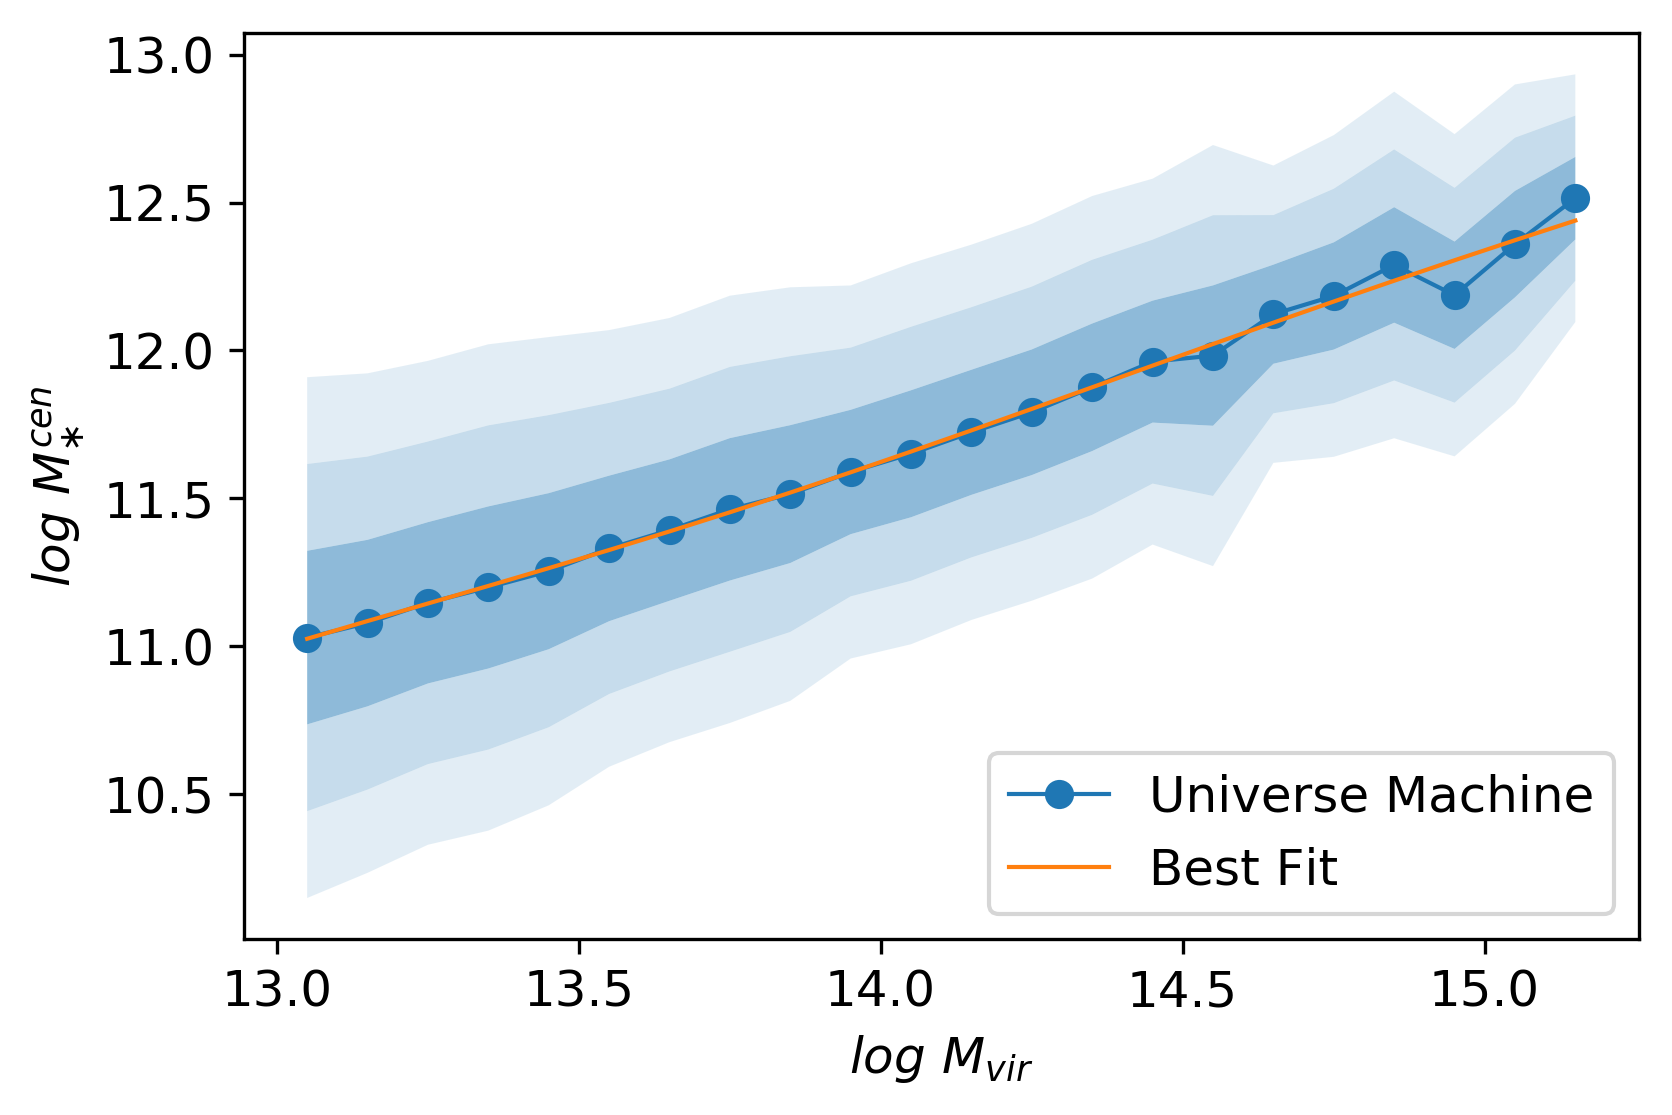

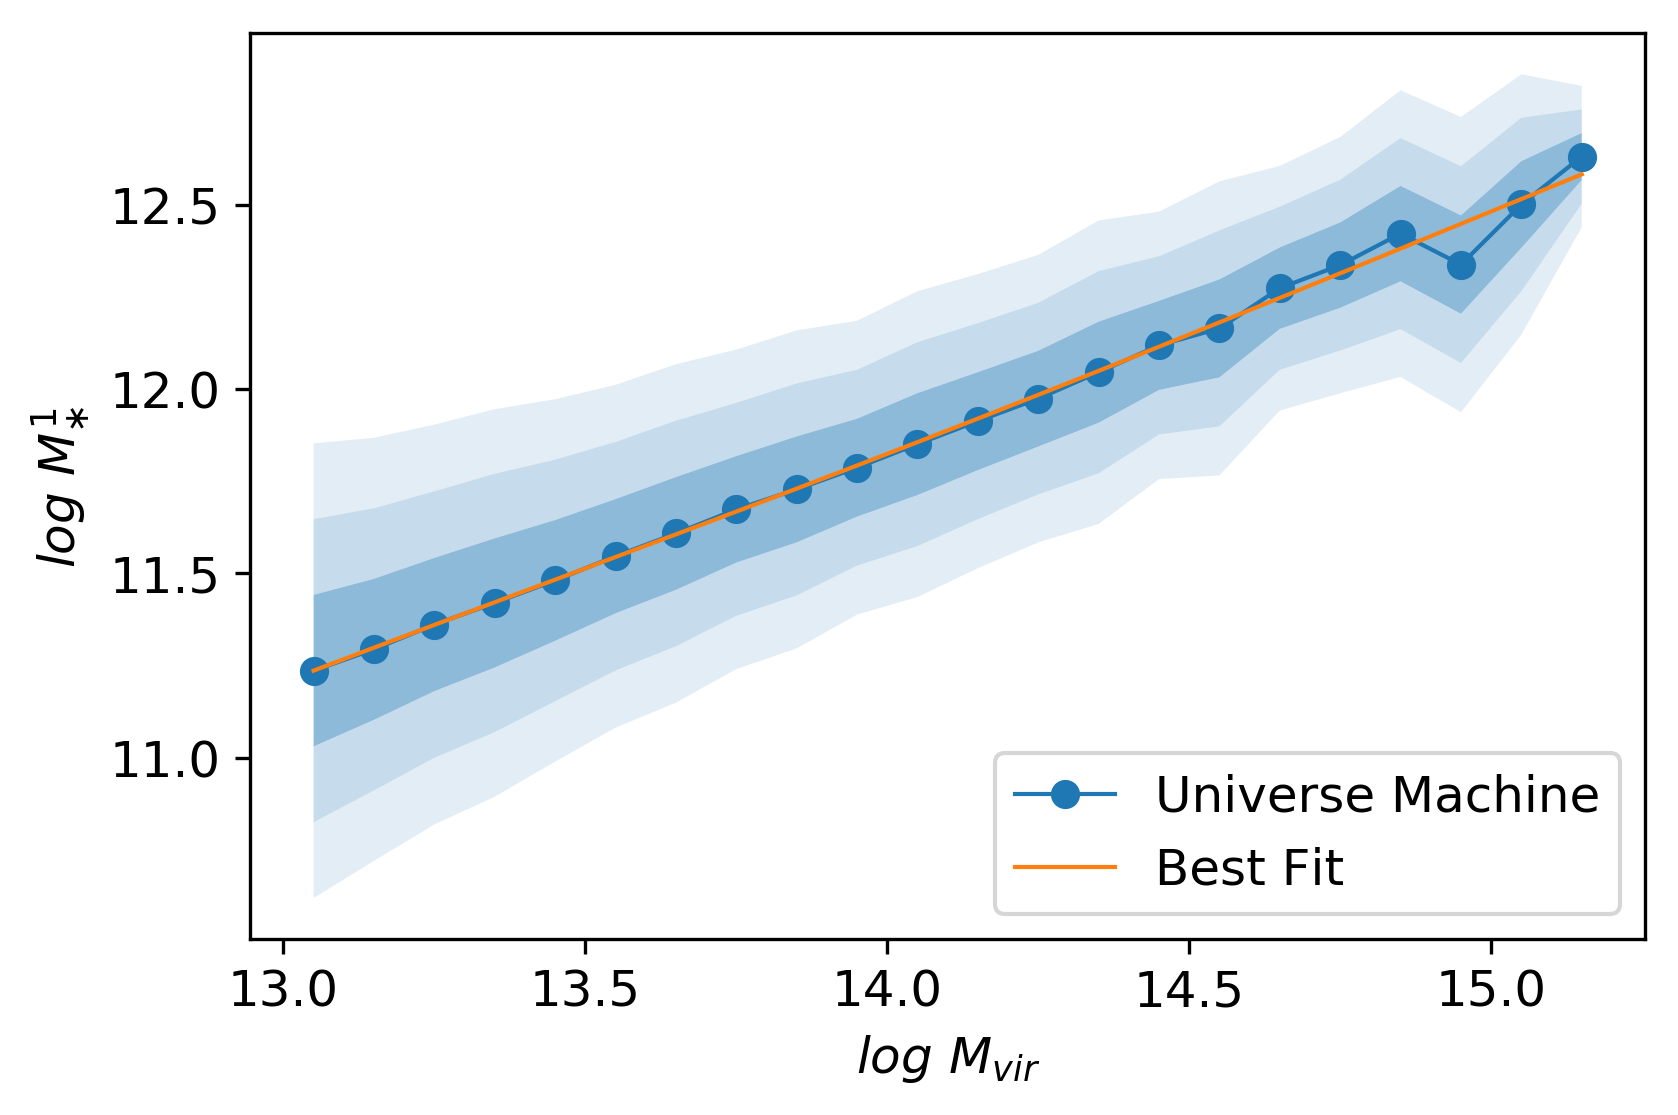

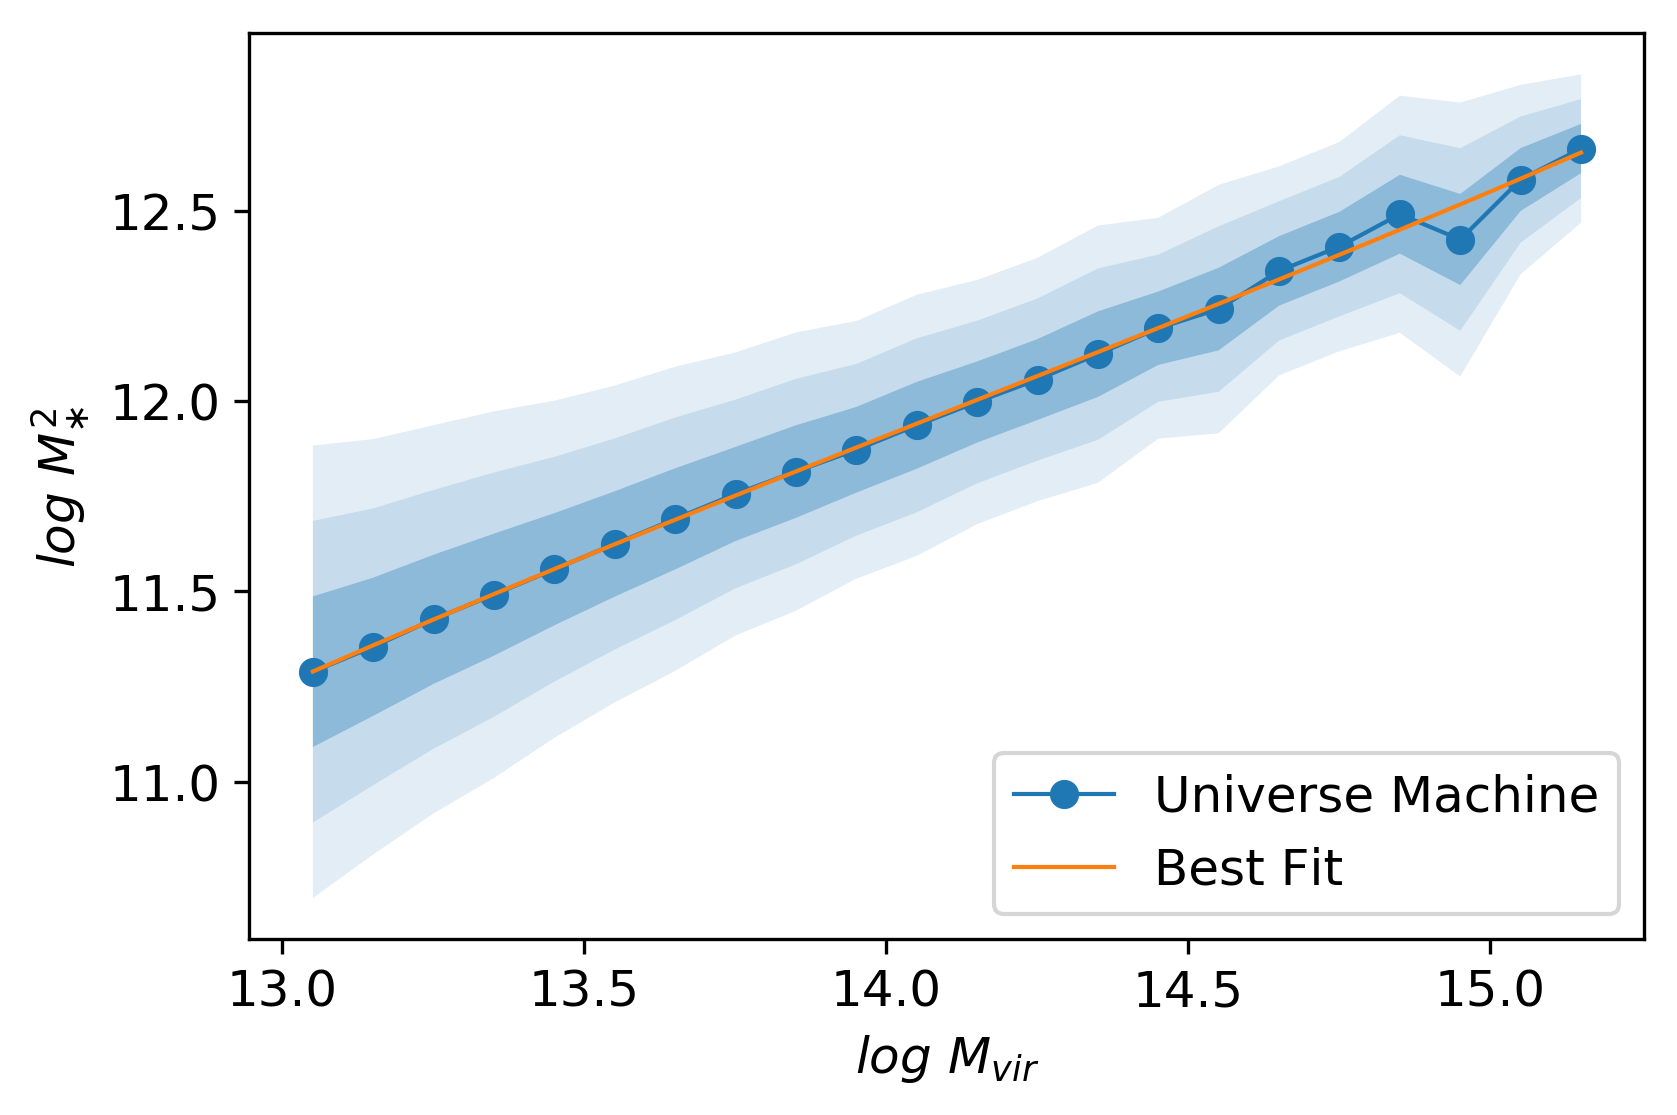

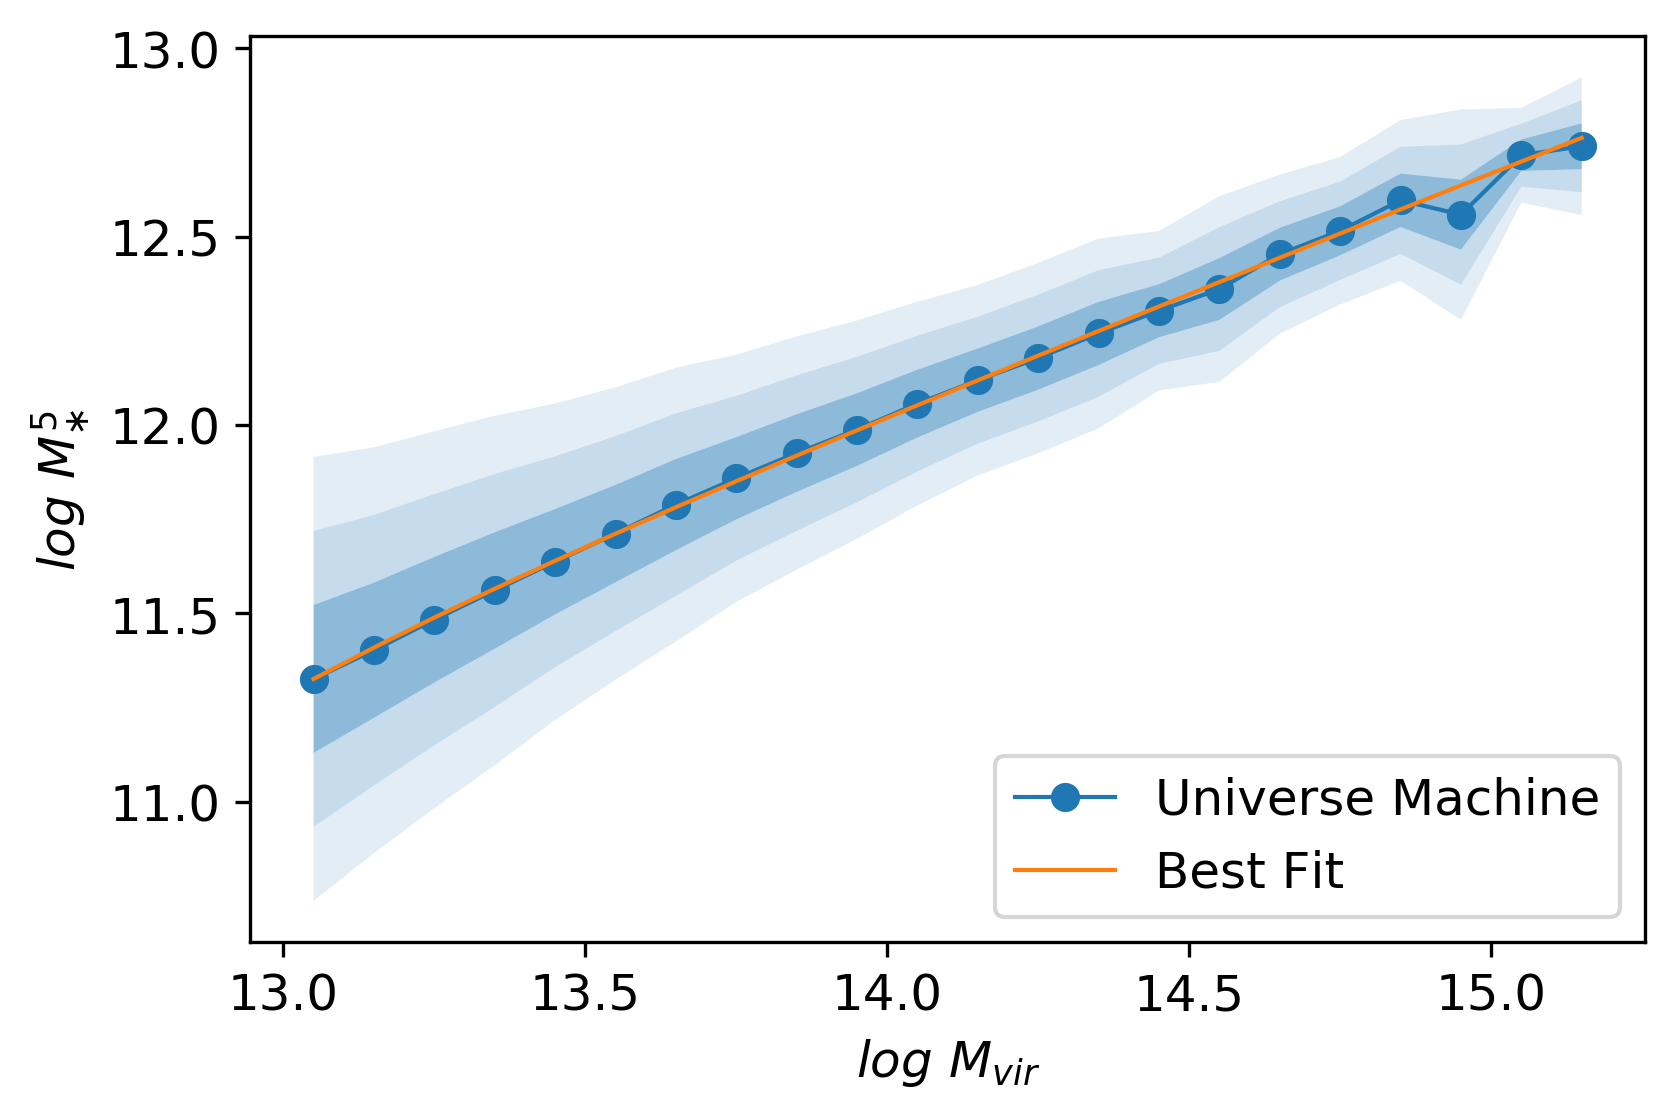

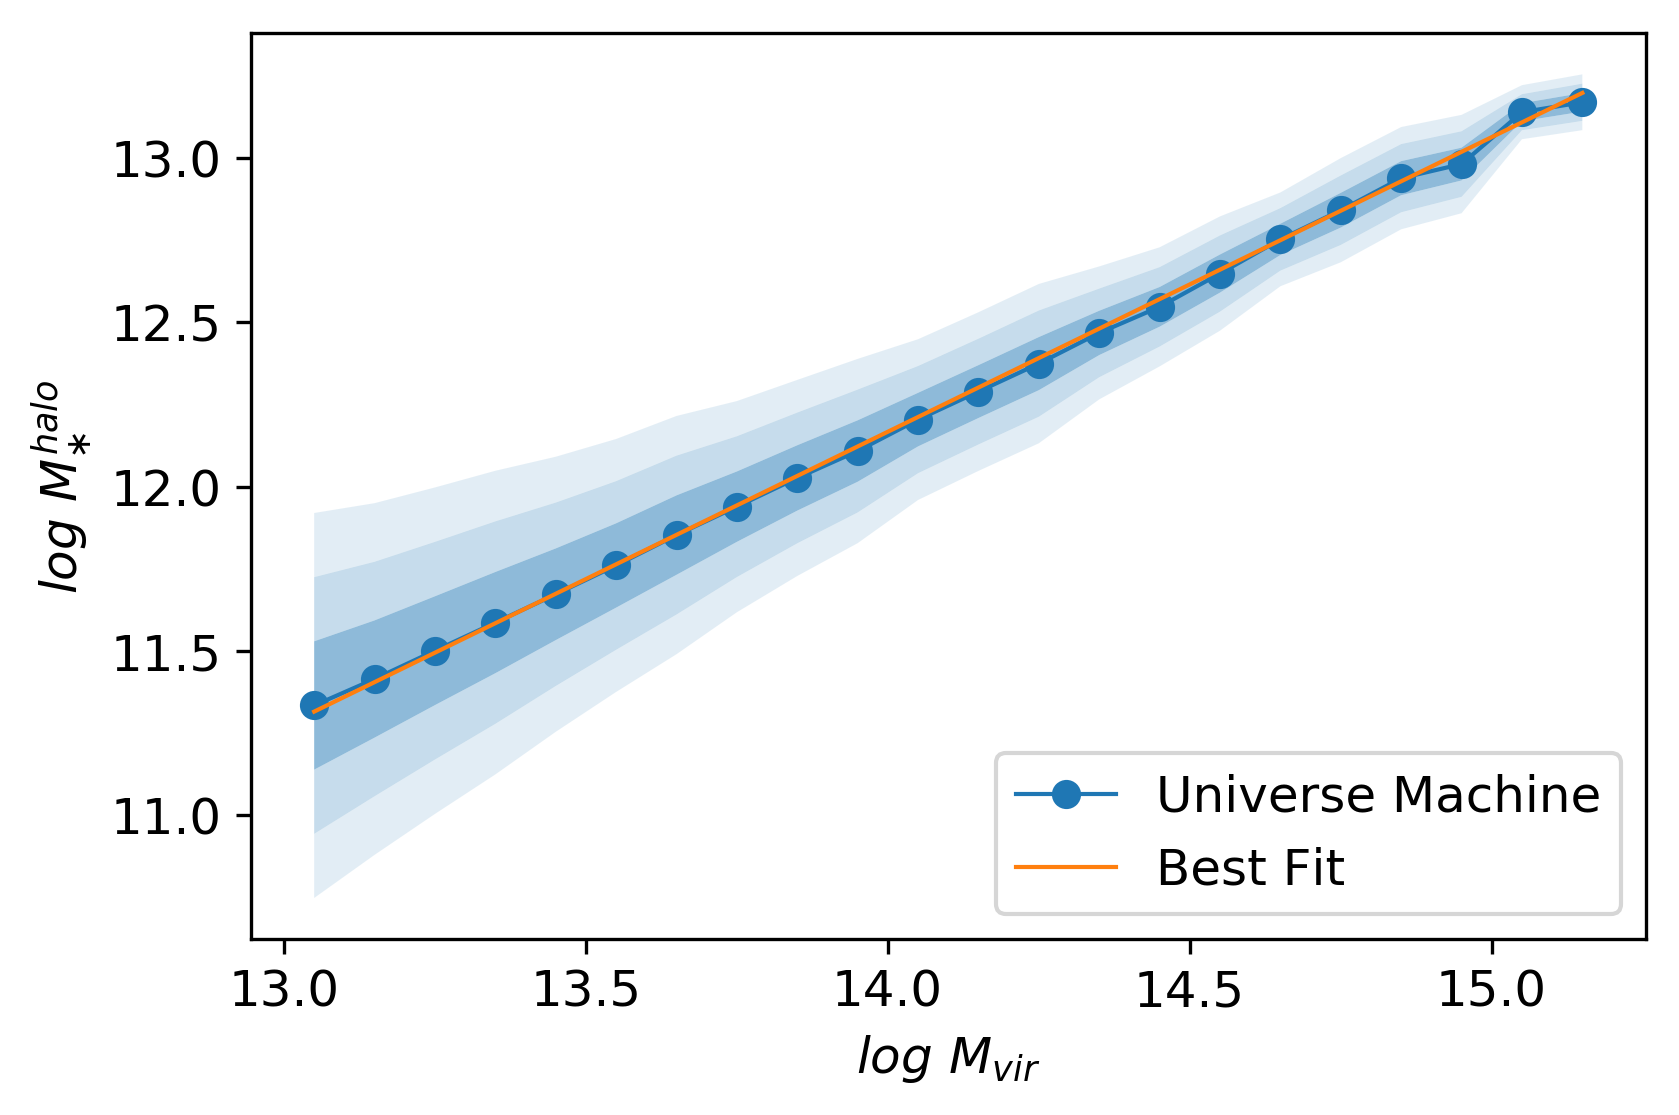

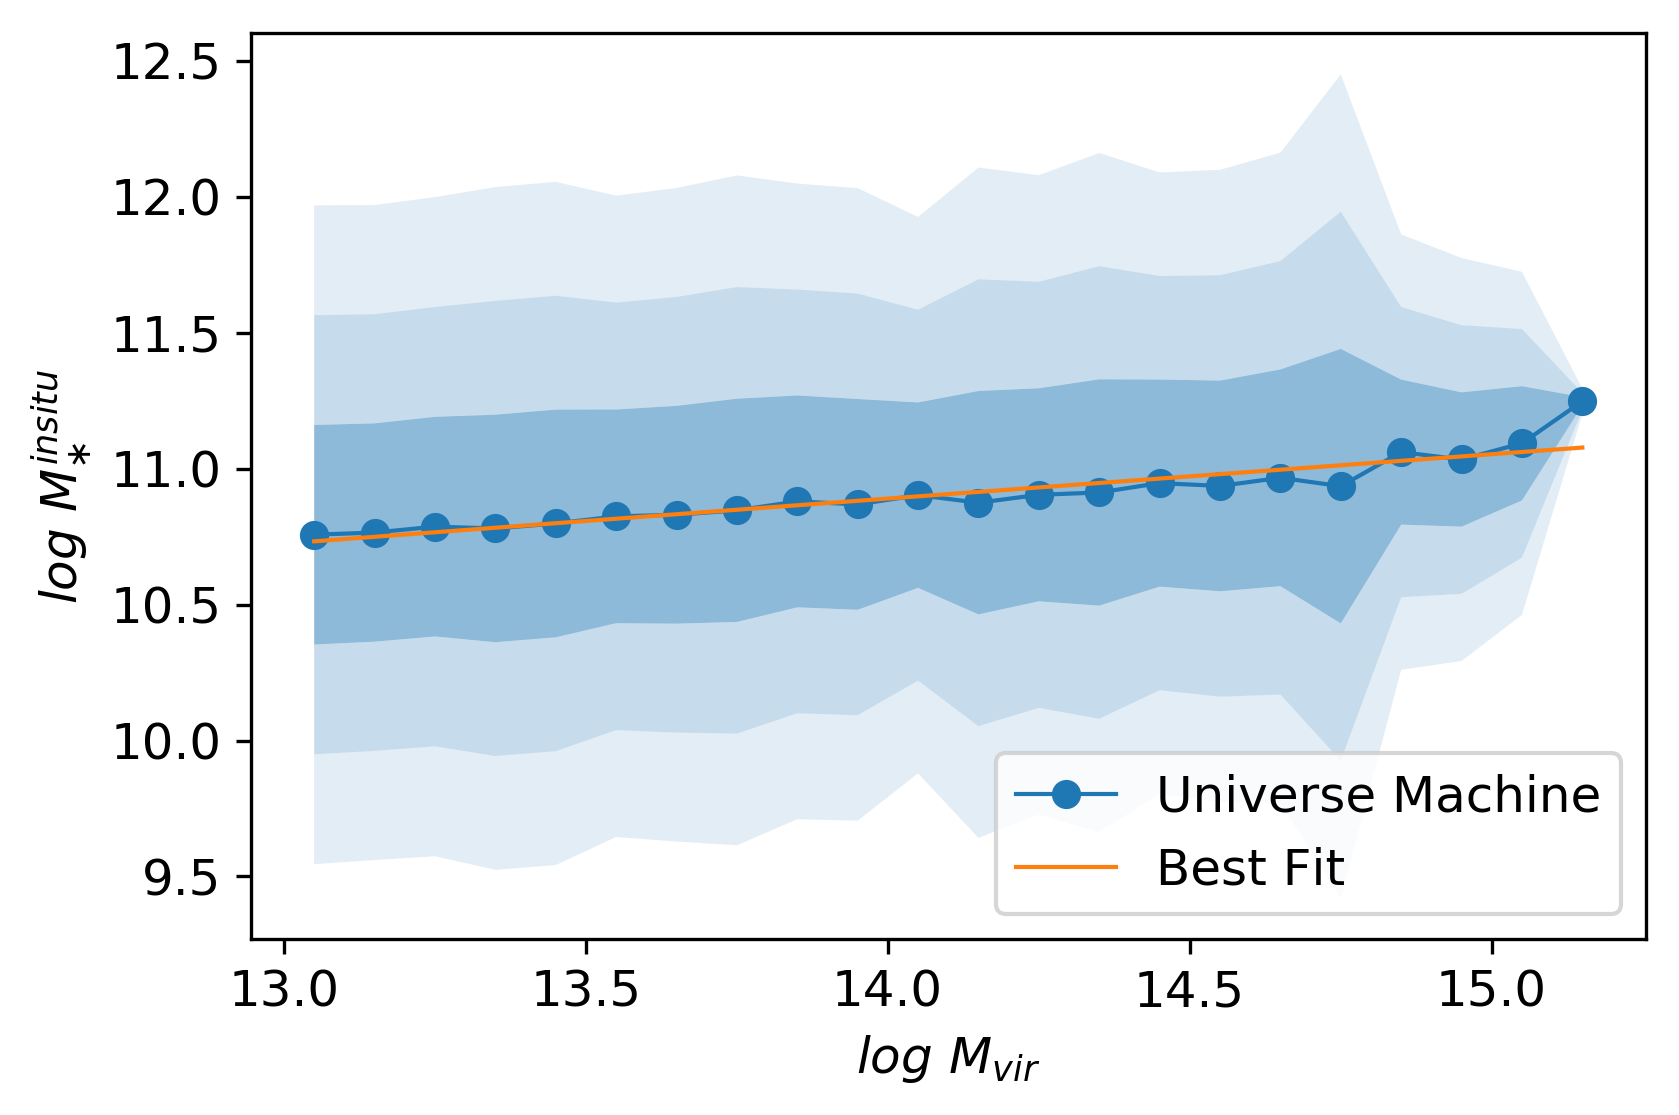

In [9]:
for key in data_halo_cut.keys():
    p.sm_hm.sm_vs_dm(data_halo_cut[key]["data"], key, fit=data_halo_cut[key]["fit"])

# Intro Plot

Intro everything by showing the SM-HM plot + some of the sigma plots

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.sm_hm.sm_vs_dm(data_halo_cut["halo"]["data"], "halo", fit=data_halo_cut["halo"]["fit"], ax=axes[0])
p.scatter.in_sm_at_fixed_hm_incl_lit(data_halo_cut, ax=axes[1])
plt.tight_layout()
#plots.sm_vs_dm(data_halo_cut["cen"]["data"], "cen", fit=data_halo_cut["cen"]["fit"])

[14726, 9279, 5597, 3294, 1822, 974, 469, 203, 92, 27, 6]


# SMHM ratio scatter for clusters

What happens if we start to plot this relation for multiple members of the cluster?

[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[6, 17, 38, 77, 182, 388, 858]
[7, 17, 37, 81, 177, 390, 867]
[7, 16, 37, 82, 175, 387, 856]
[7, 17, 36, 82, 178, 391, 853]
[6, 18, 37, 80, 179, 392, 858]


(0.0, 0.36248945748431954)

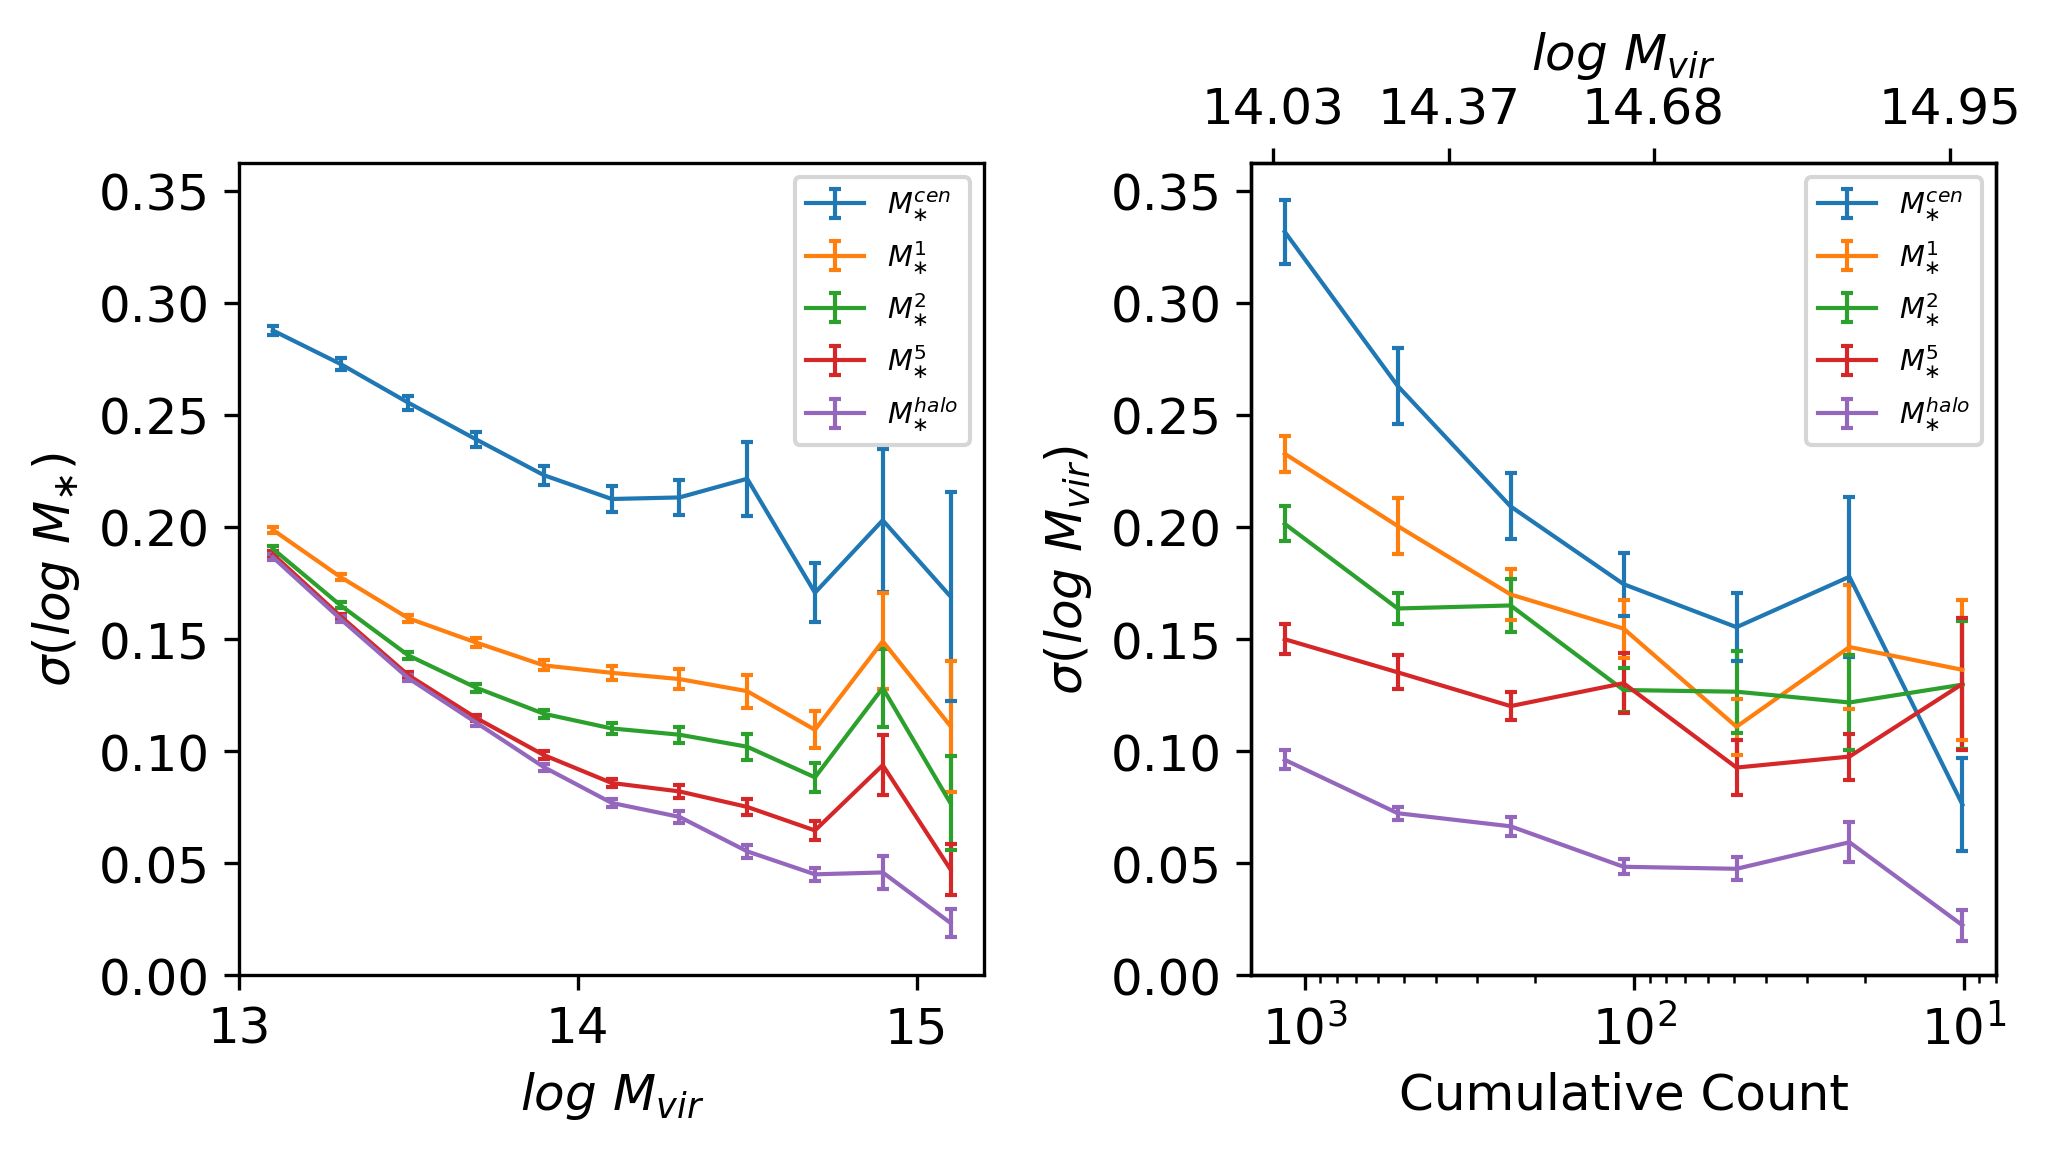

In [73]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.scatter.in_sm_at_fixed_hm(data_halo_cut, ax=axes[0])
p.scatter.in_hm_at_fixed_number_density(data_stellar_cut, ax=axes[1])
plt.tight_layout()
axes[0].set_ylim(axes[1].get_ylim())

# CSMF


In [38]:
fits.density_at_mass(data_stellar_cut, "cen", fits.mass_at_density(data_stellar_cut, "cen", 1e2))

100.0

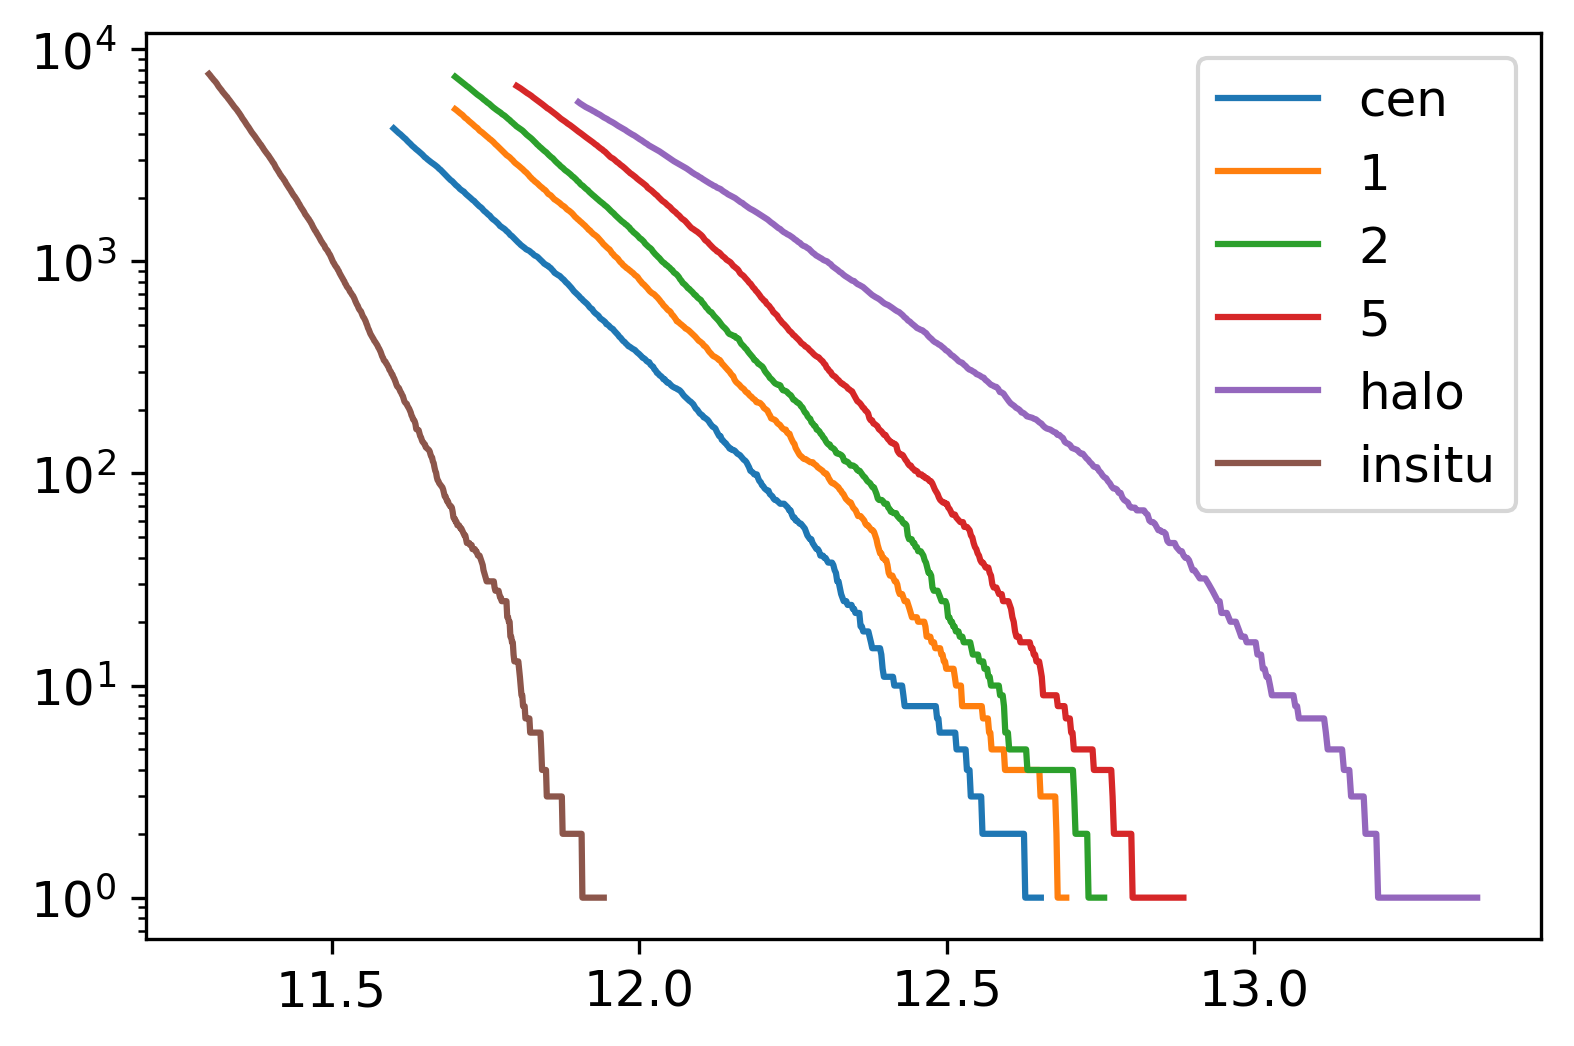

In [31]:
_, ax = plt.subplots()
for key in data_stellar_cut.keys():
    smf_data = data_stellar_cut[key]["smf"]
    ax.plot(smf_data[0], smf_data[1], label=key)
ax.set_yscale("log")
ax.legend()

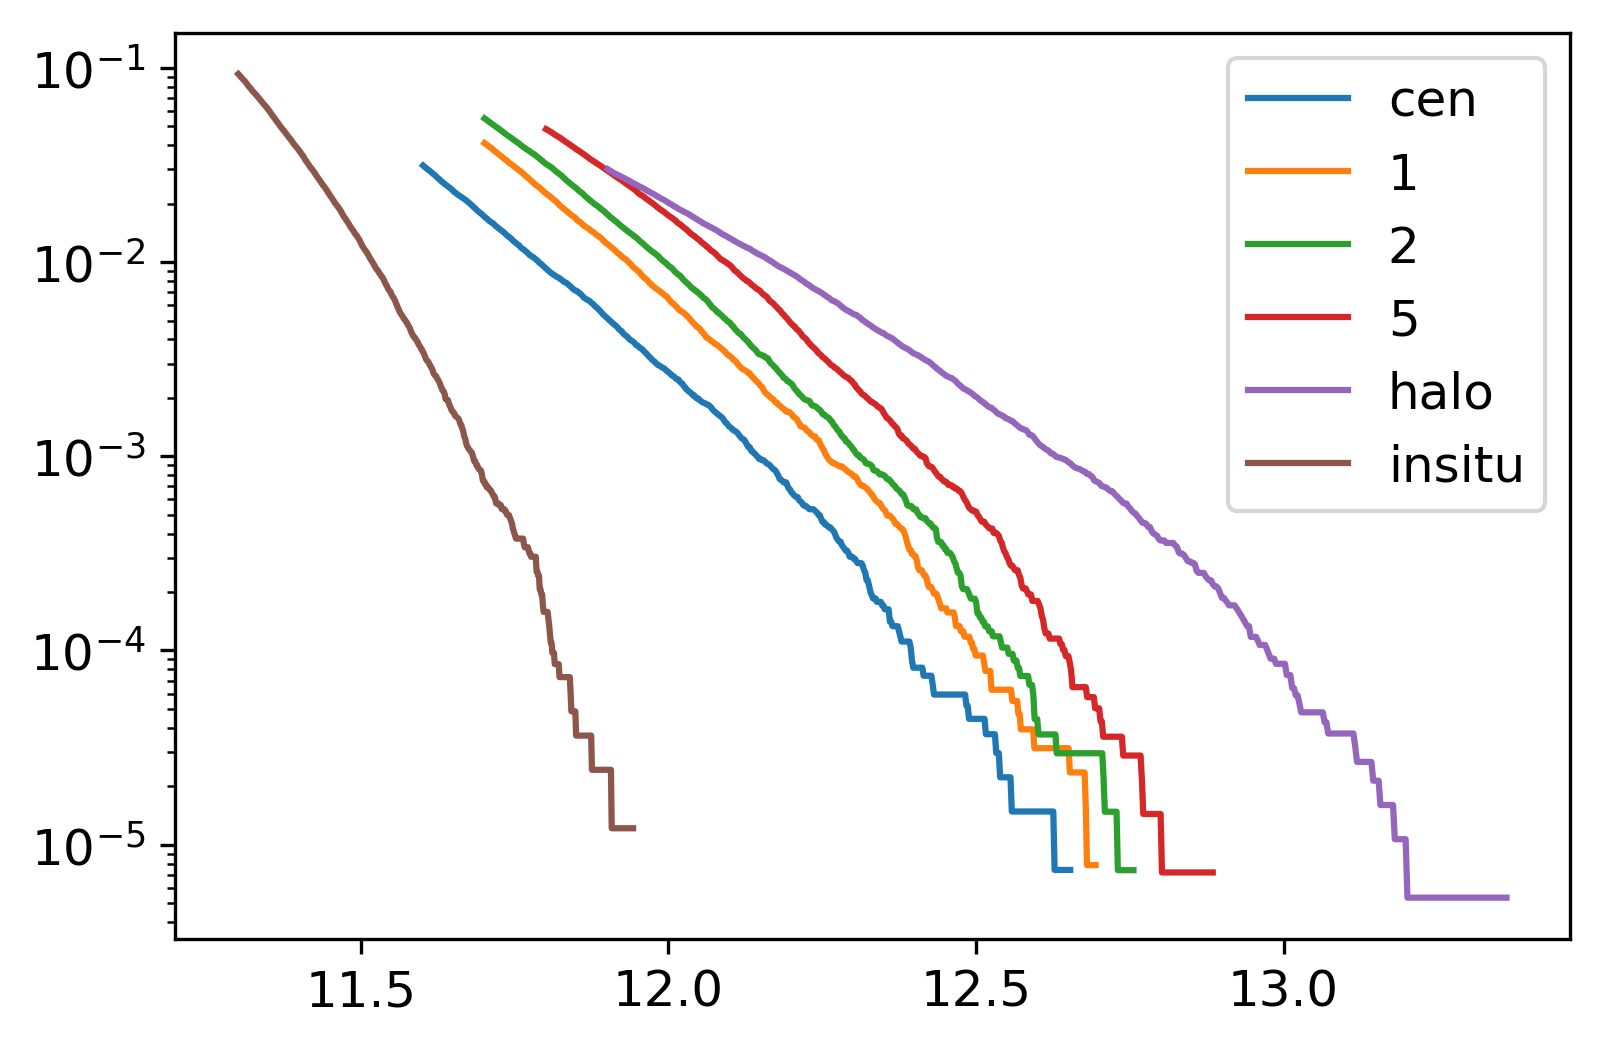

In [141]:
_, ax = plt.subplots()
for key in data_stellar_cut.keys():
    smf_data = data_stellar_cut[key]["smf"]
    ax.plot(smf_data[0], smf_data[1], label=key)
ax.set_yscale("log")
ax.legend()

### Comparison with HSC etc

In [202]:
hsc_smf_file_m10 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm10_smf_default.fits"
hsc_smf_file_m100 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm100_smf_default.fits"

m10_smf = astropy.io.fits.open(hsc_smf_file_m10)[1].data
m100_smf = astropy.io.fits.open(hsc_smf_file_m100)[1].data

In [ ]:
print(m10_smf.dtype)
print(m10_smf)

Dropped 0 galaxies with mass of 0
Dropped 0 galaxies with mass of 0
Dropped 4 galaxies with mass of 0


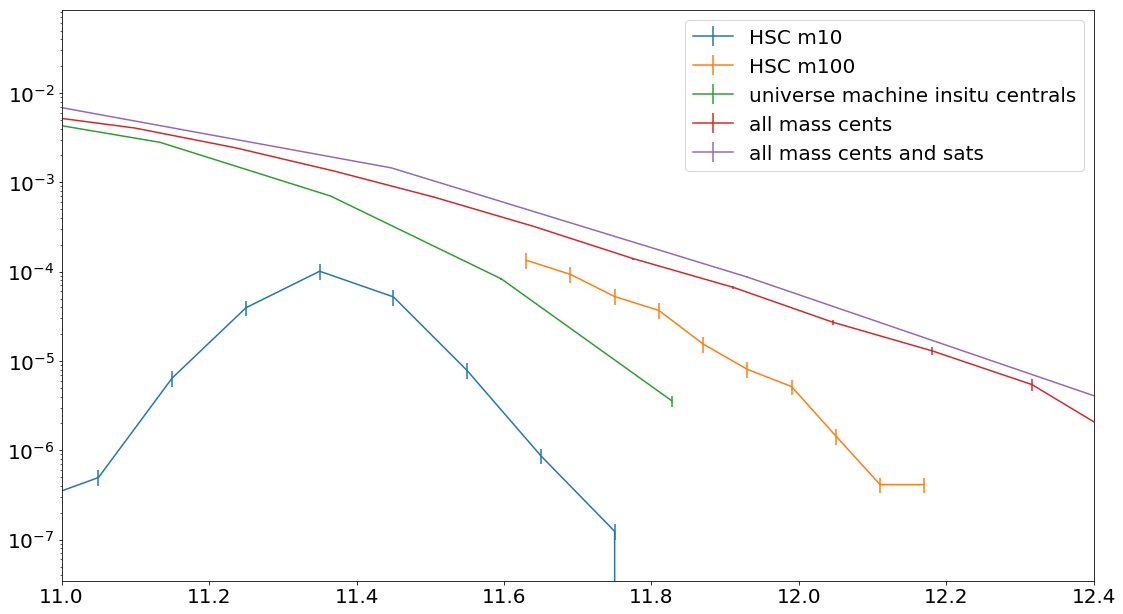

In [210]:
def plot_sim_smf(stellar_masses, ax, label):

    nonzero_stellar_masses = np.log10(stellar_masses[stellar_masses != 0])
    print("Dropped {} galaxies with mass of 0".format(len(stellar_masses) - len(nonzero_stellar_masses)))

    sim_volume = 400**3 # https://redwoodforest.slack.com/archives/C5W6EQCAU/p1513187949000425 SMDPL
    num_bins = 30
    x, y, err = smf.compute_smf(
        nonzero_stellar_masses, sim_volume, num_bins, 
        np.min(nonzero_stellar_masses), np.max(nonzero_stellar_masses),
    )
    ax.errorbar(x, y, yerr = err, label=label)


fig, ax = plt.subplots()
ax.errorbar(m10_smf["logm_mean"], m10_smf["smf"], yerr = m10_smf["smf_err"], label="HSC m10")
ax.errorbar(m100_smf["logm_mean"], m100_smf["smf"], yerr = m100_smf["smf_err"], label="HSC m100")
plot_sim_smf(centrals["sm"], ax, "universe machine insitu centrals")
plot_sim_smf(centrals["sm"] + centrals["icl"], ax, "all mass cents")
plot_sim_smf(np.append(centrals["sm"] + centrals["icl"], satellites["sm"] + satellites["icl"]), ax, "all mass cents and sats")
ax.legend()
ax.set(
    yscale="log",
    xlim=[11, 12.4],
)
fig.set_size_inches(18.5, 10.5)

# Richness

What about richness? Does that have a relation with scatter at fixed halo mass

In [146]:
fits.density_at_richness(data_stellar_cut, "cen", fits.richness_at_density(data_stellar_cut, "cen", 2e-4))

0.00019187769396551723

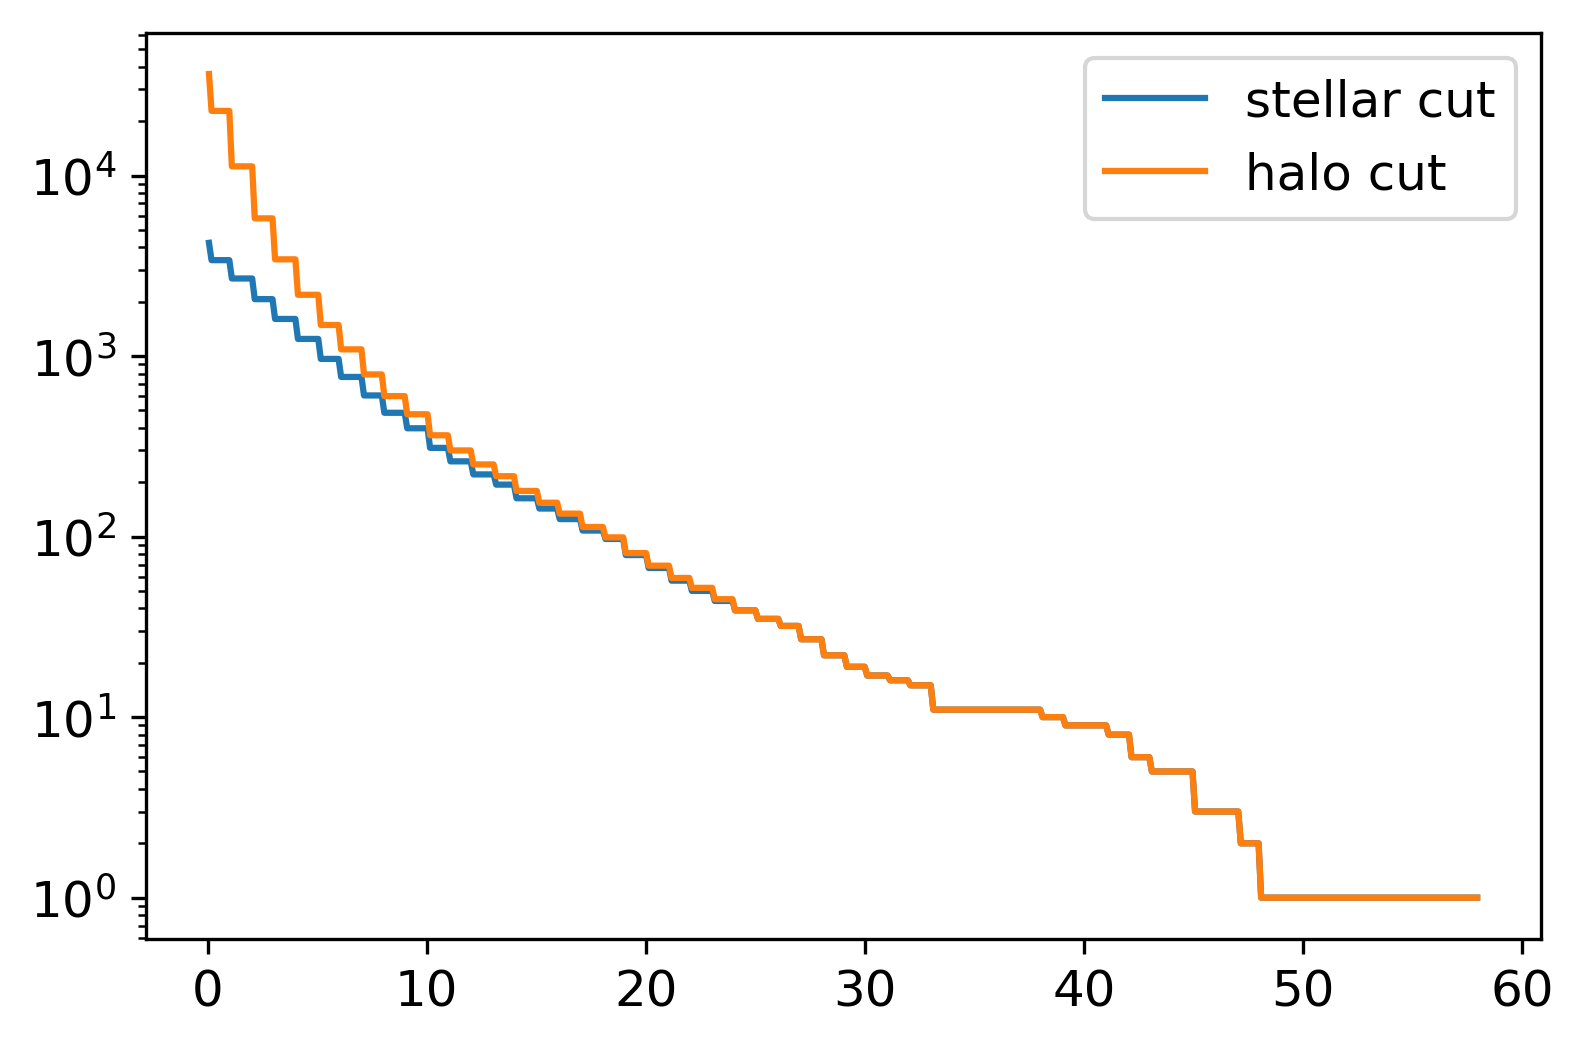

In [35]:
#p.scatter.in_richness_at_fixed_hm(data_halo_cut)
#p.scatter.in_hm_at_fixed_richness_number_density(data_stellar_cut)

_, ax = plt.subplots()
rmf_data = data_stellar_cut["cen"]["rmf"]
ax.plot(rmf_data[0], rmf_data[1], label="stellar cut")
rmf_data = data_halo_cut["cen"]["rmf"]
ax.plot(rmf_data[0], rmf_data[1], label="halo cut")
ax.set_yscale("log")
ax.legend()



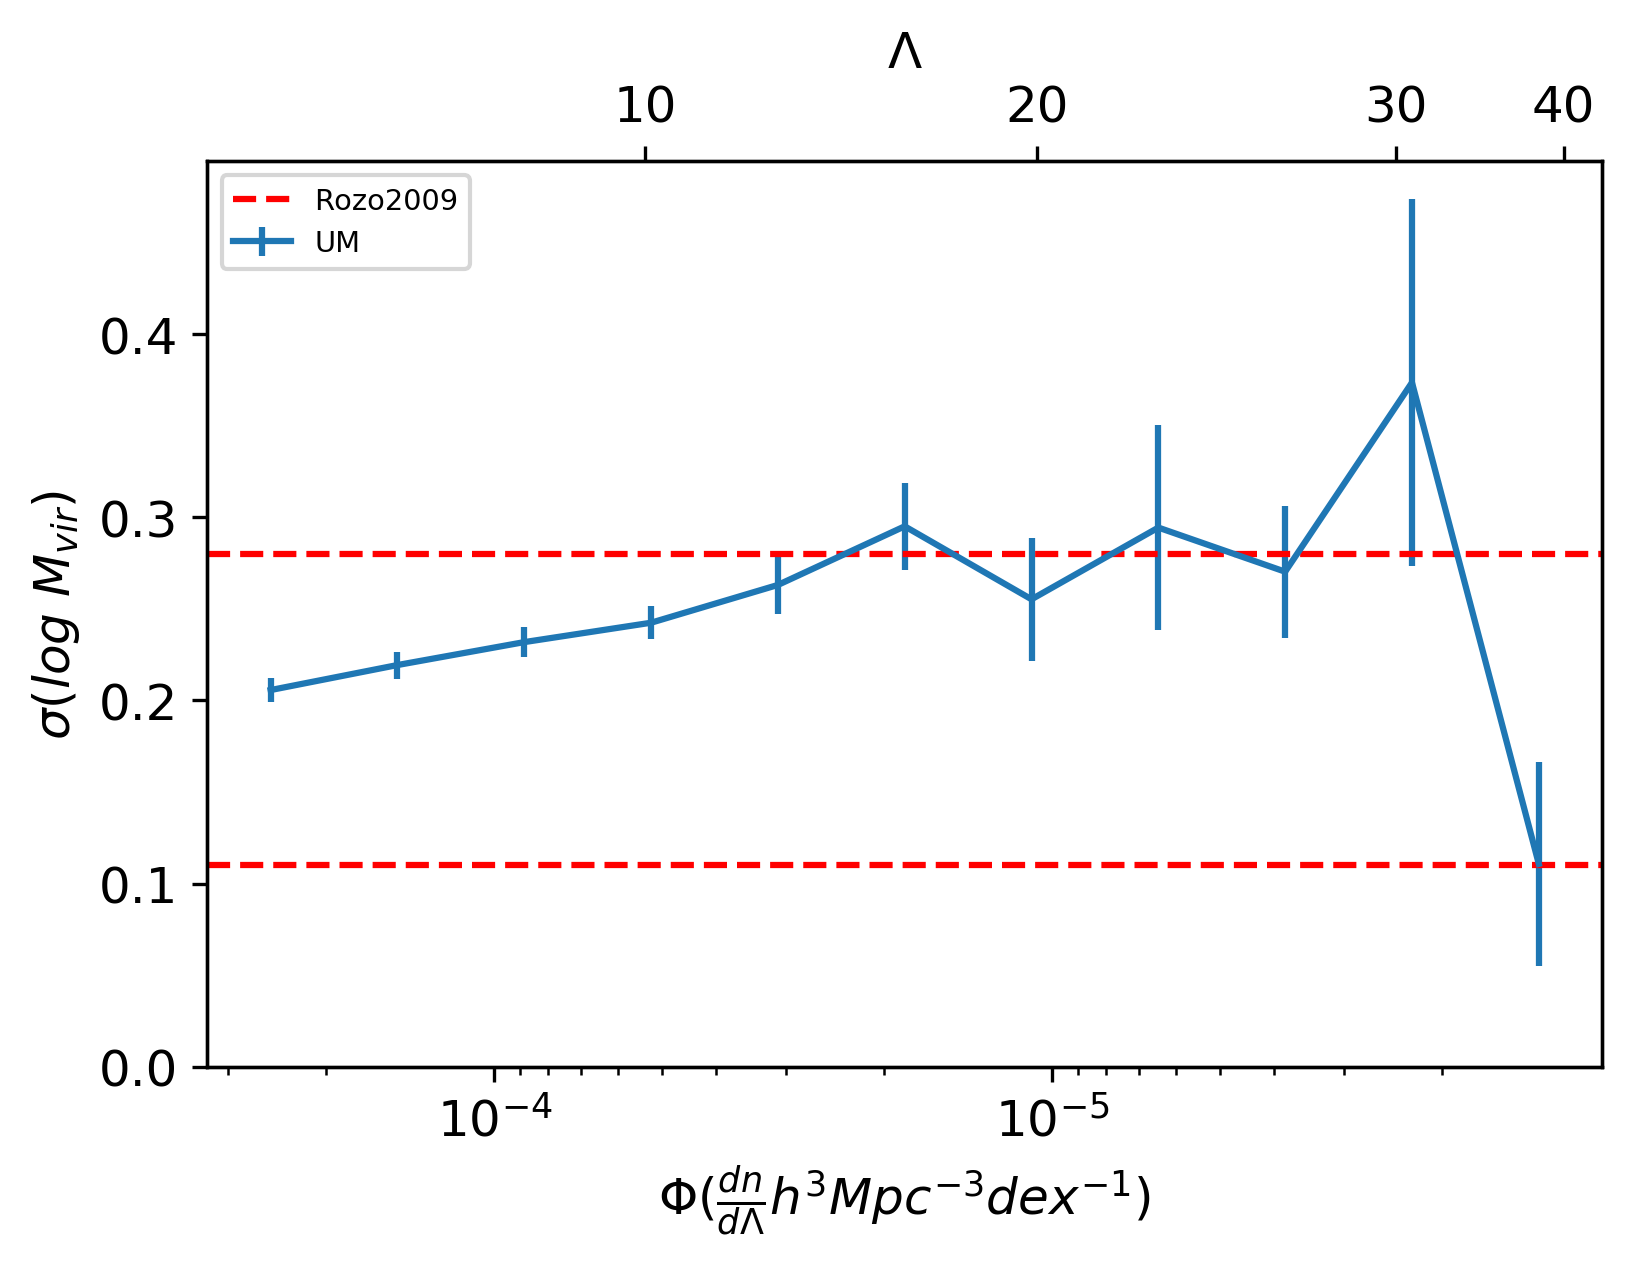

In [199]:
ax = p.scatter.in_hm_at_fixed_richness_number_density(data_stellar_cut)

### Old color plots

Out of 36491 clusters, 22803 have a richness > 0


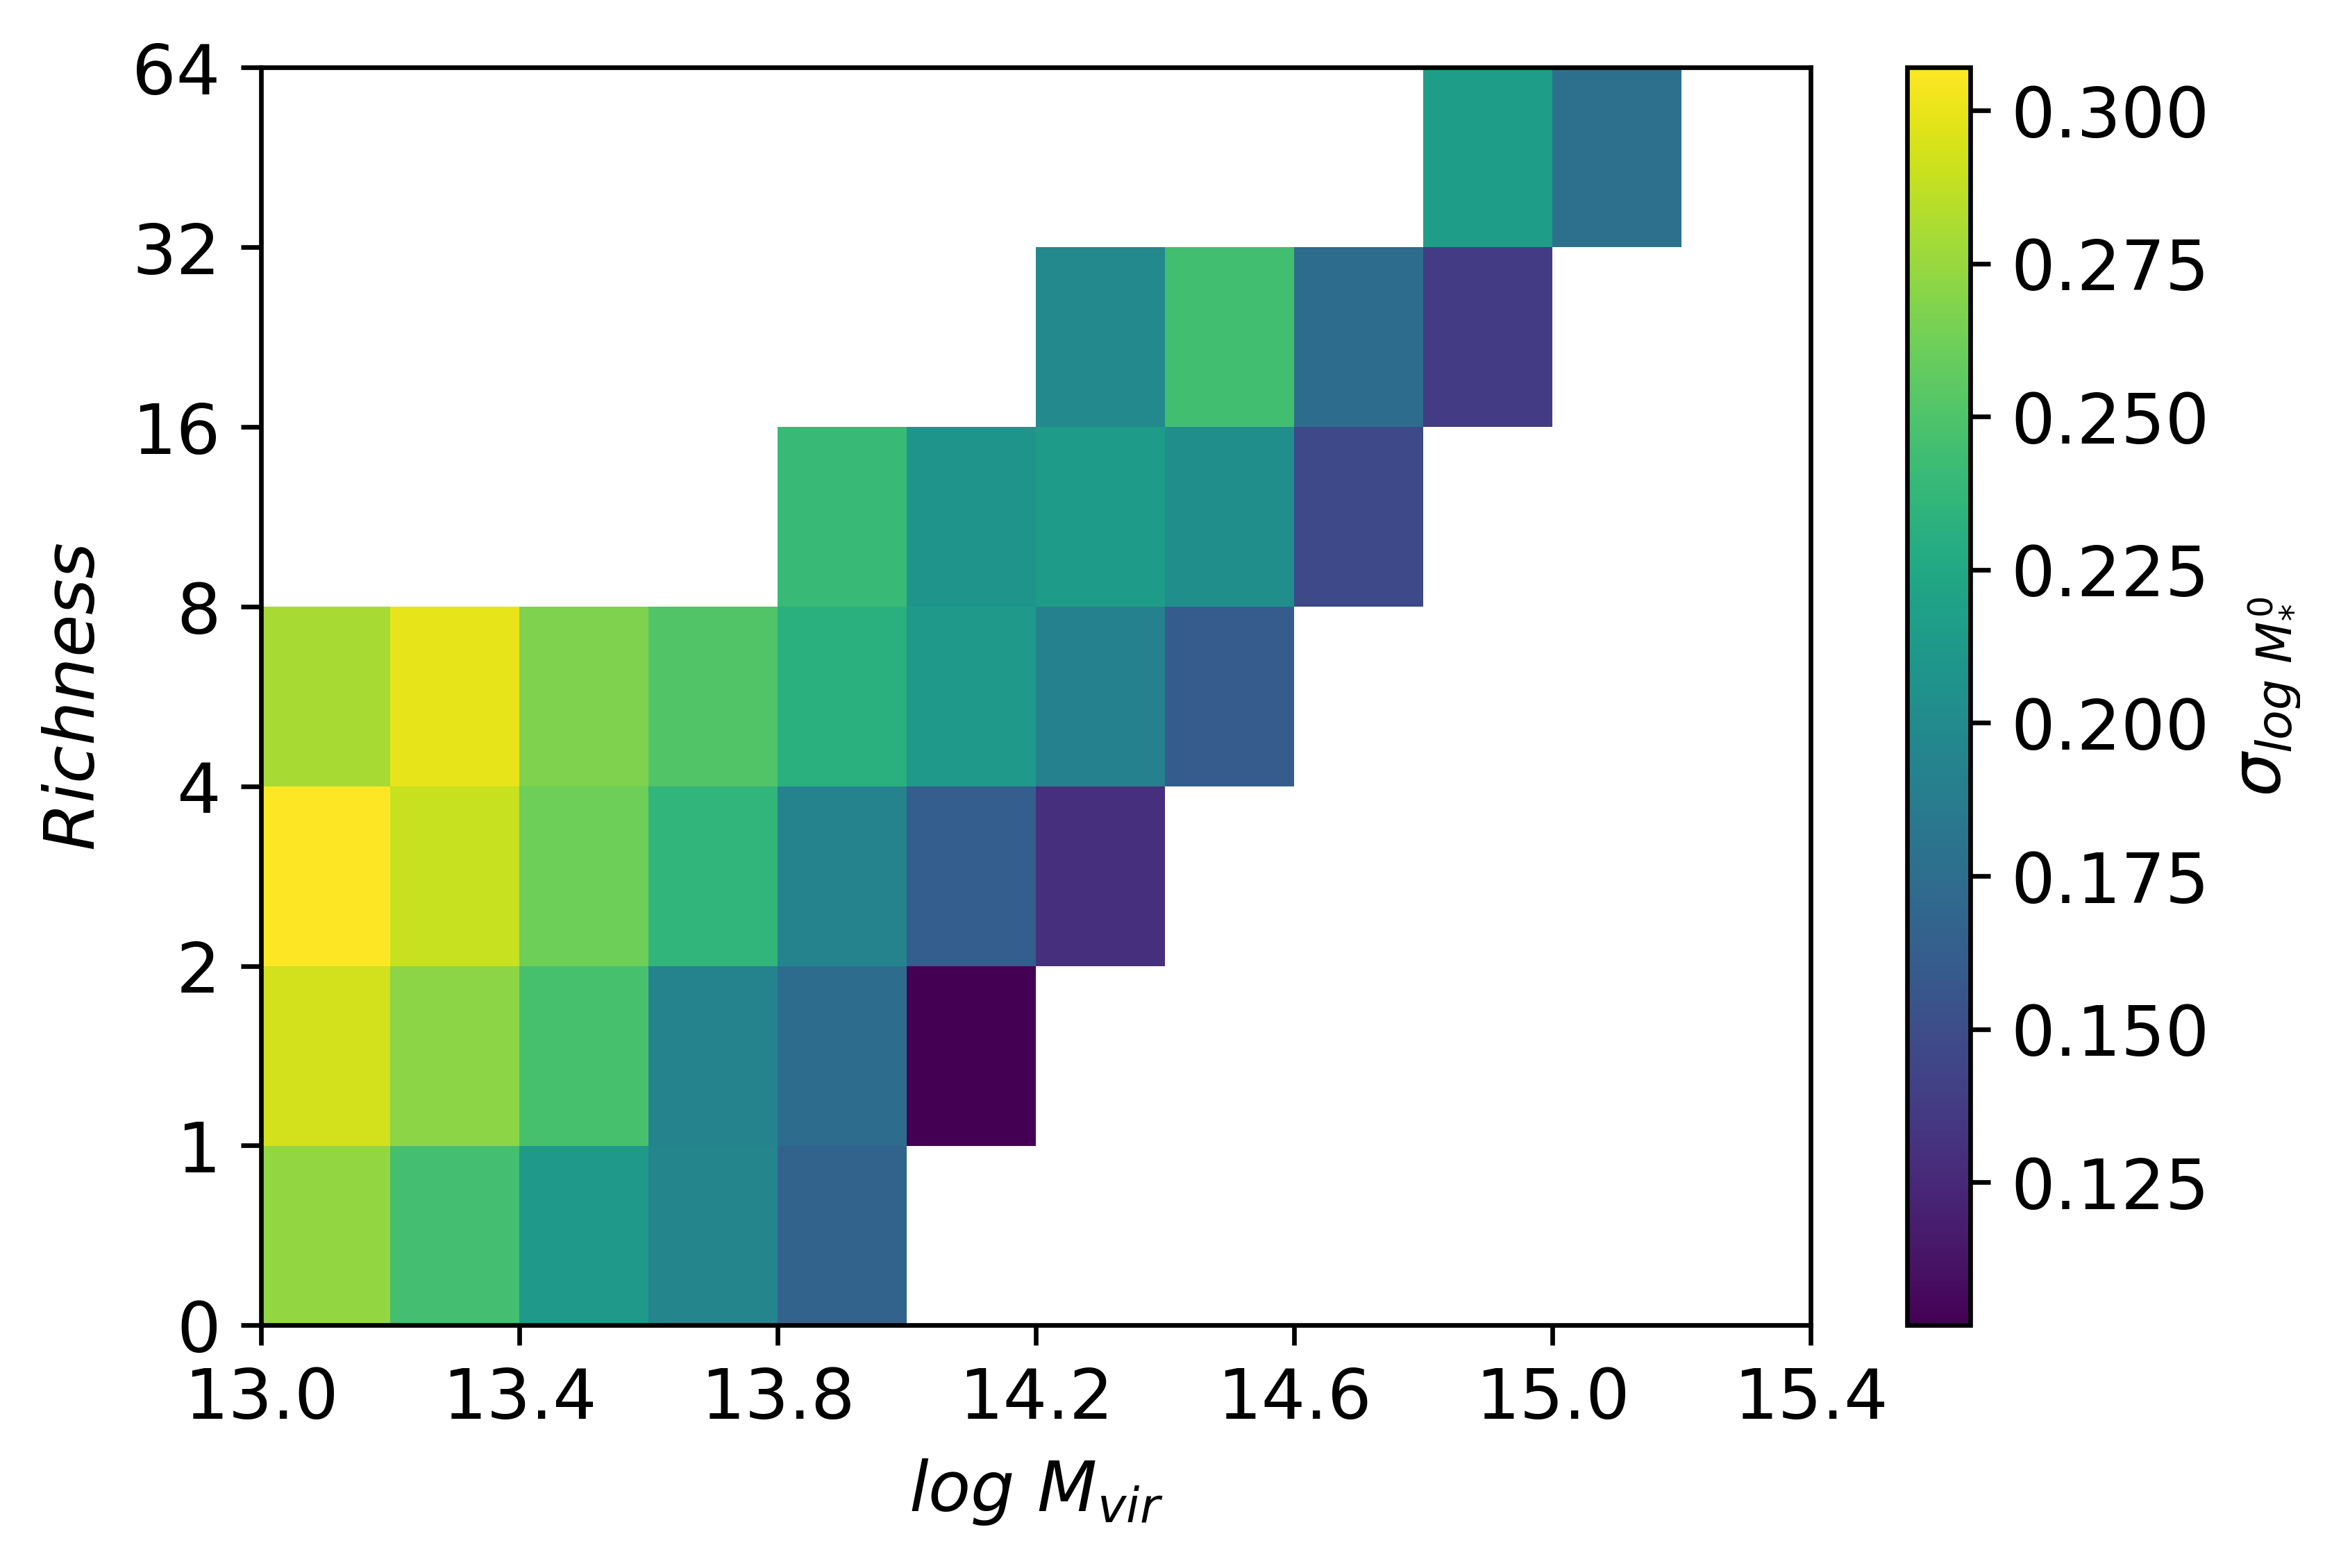

In [108]:
# Only count sats of a large enough size towards richness
minMassForRichness = 10**10.8
richness = cluster_sum.get_richness(centrals_halo_cut, satellites, minMassForRichness)
print("Out of {} clusters, {} have a richness > 0".format(len(richness), np.count_nonzero(richness)))
heatmaps.richness_and_hm_vs_sm_scatter(
    data_halo_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_halo_cut[0]["fit"],
    0,
)

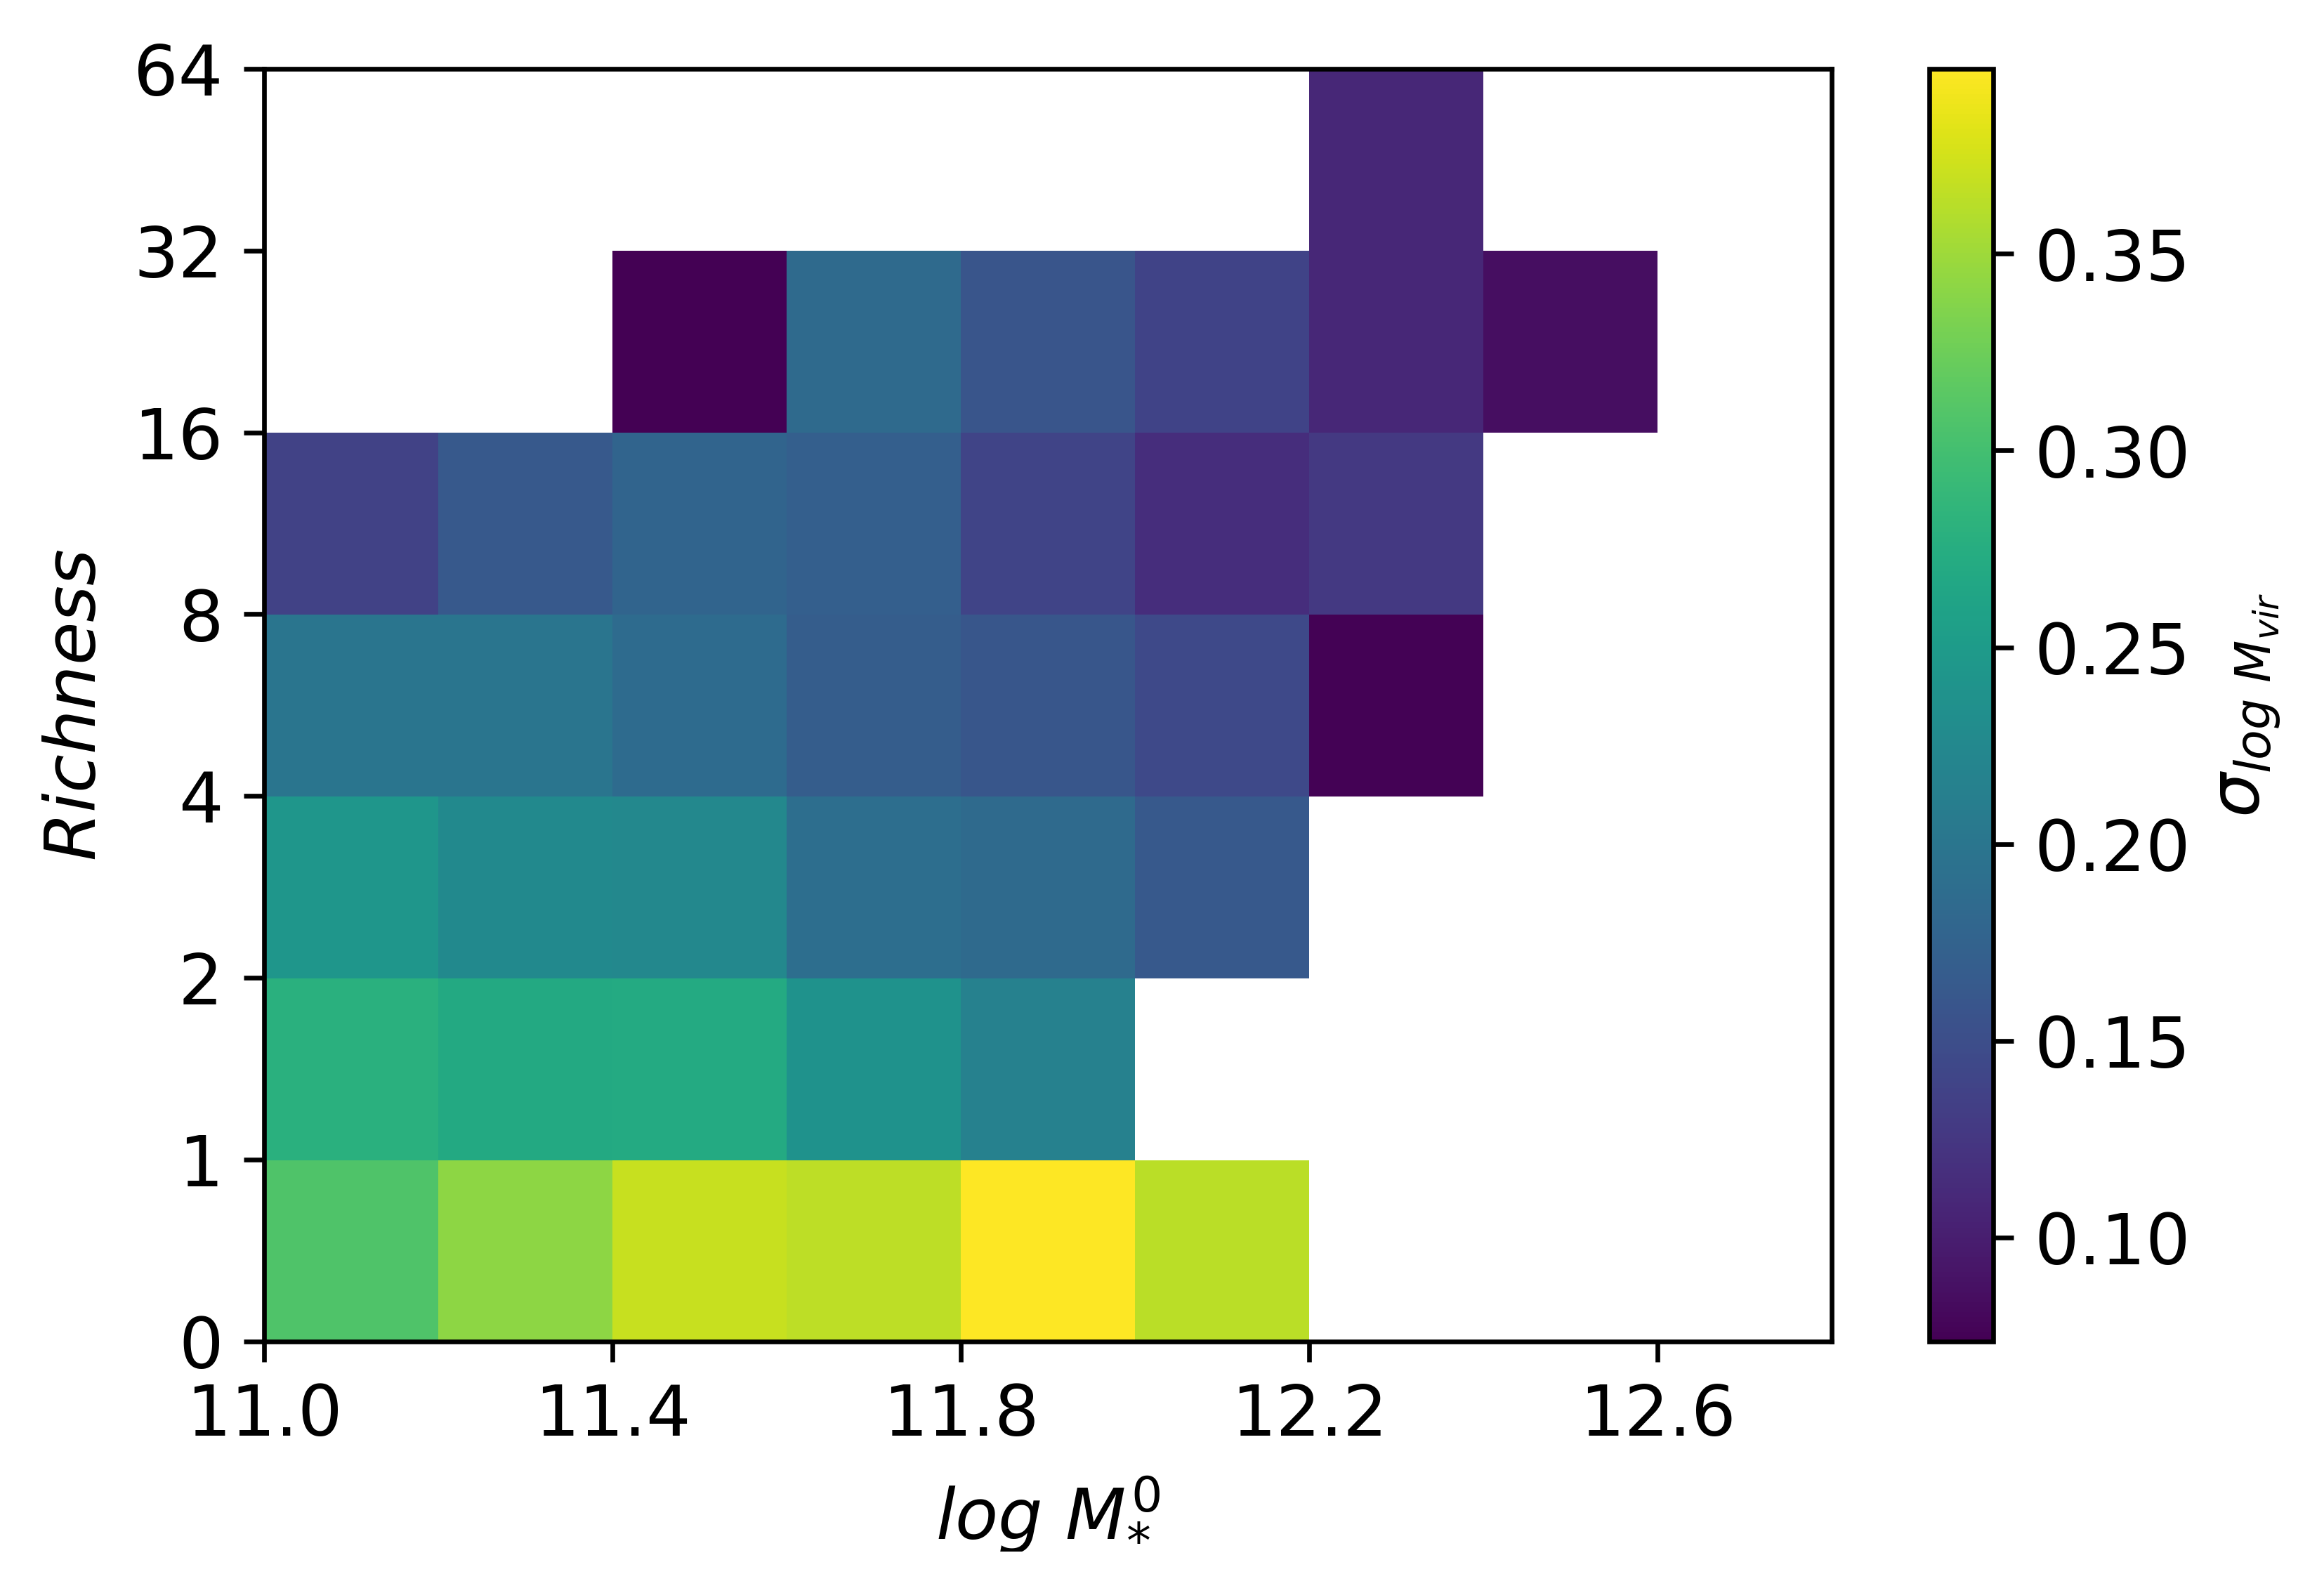

In [109]:
heatmaps.richness_and_sm_vs_hm_scatter(
    data_stellar_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_stellar_cut[0]["fit"],
    0,
)

# Concentration

Same as richness but for concentration

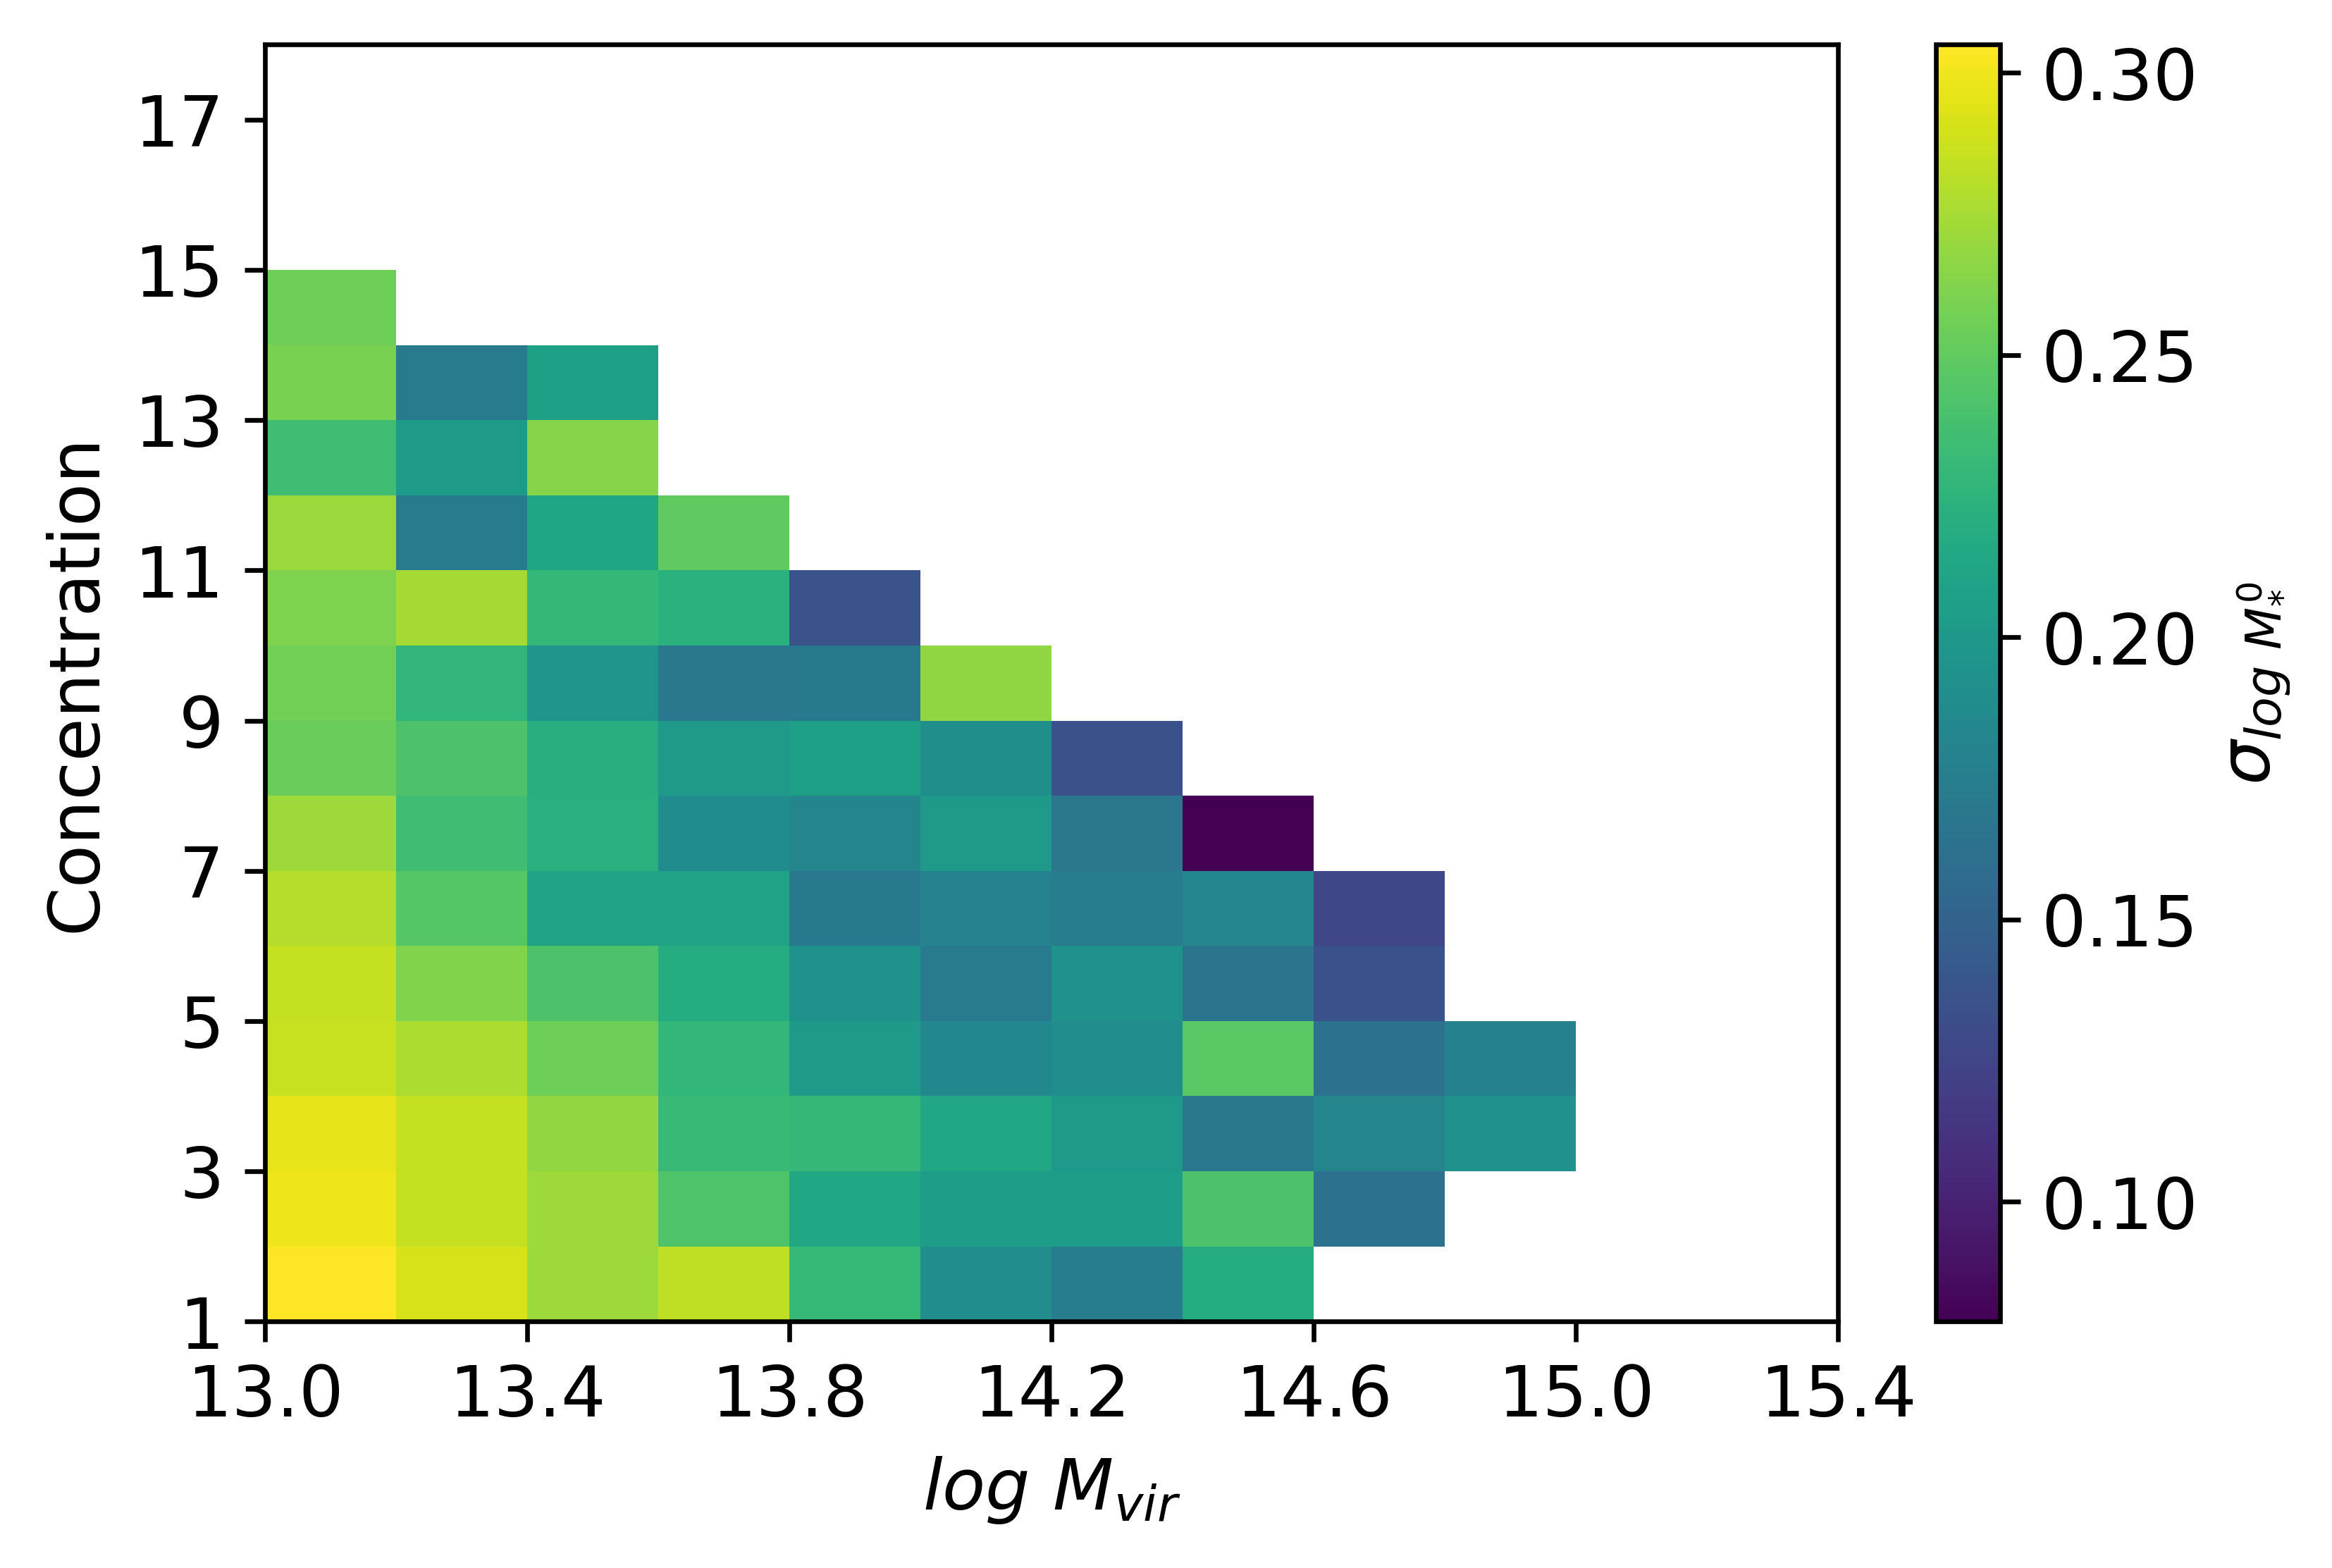

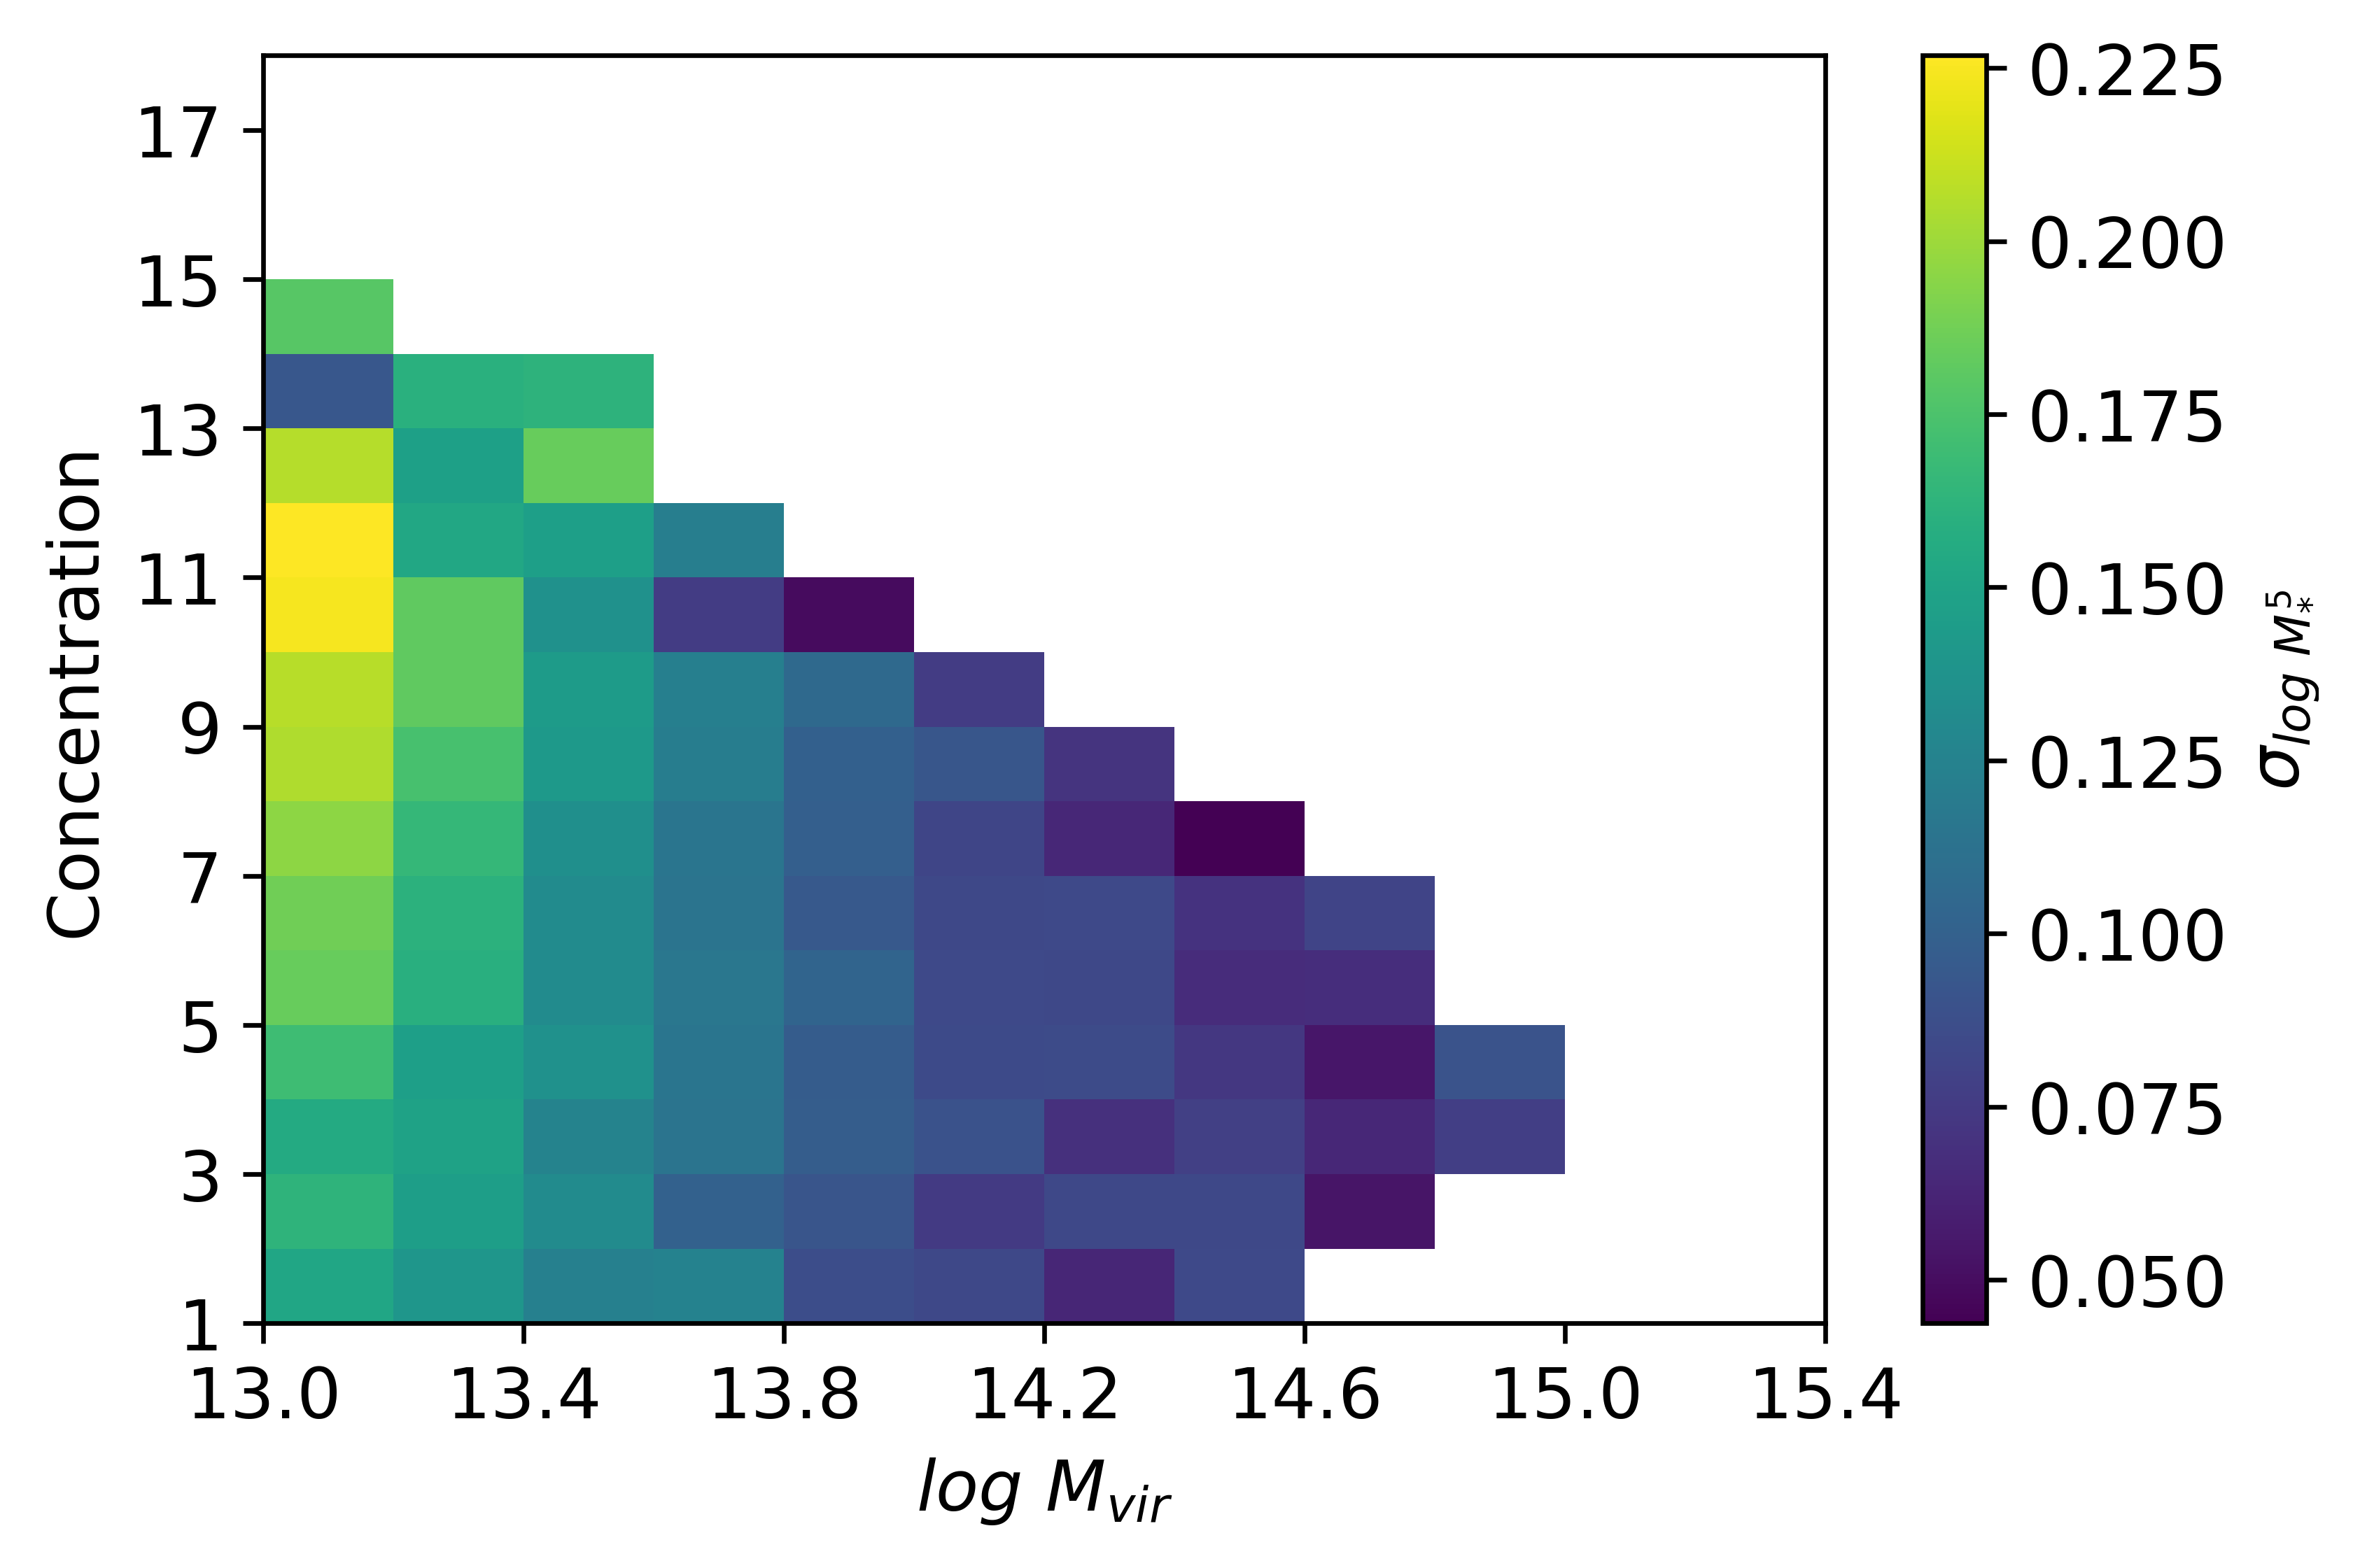

In [106]:
heatmaps.concentration_and_hm_vs_sm_scatter(data_halo_cut[0]["data"], data_halo_cut[0]["fit"], 0)
heatmaps.concentration_and_hm_vs_sm_scatter(data_halo_cut[5]["data"], data_halo_cut[5]["fit"], 5)

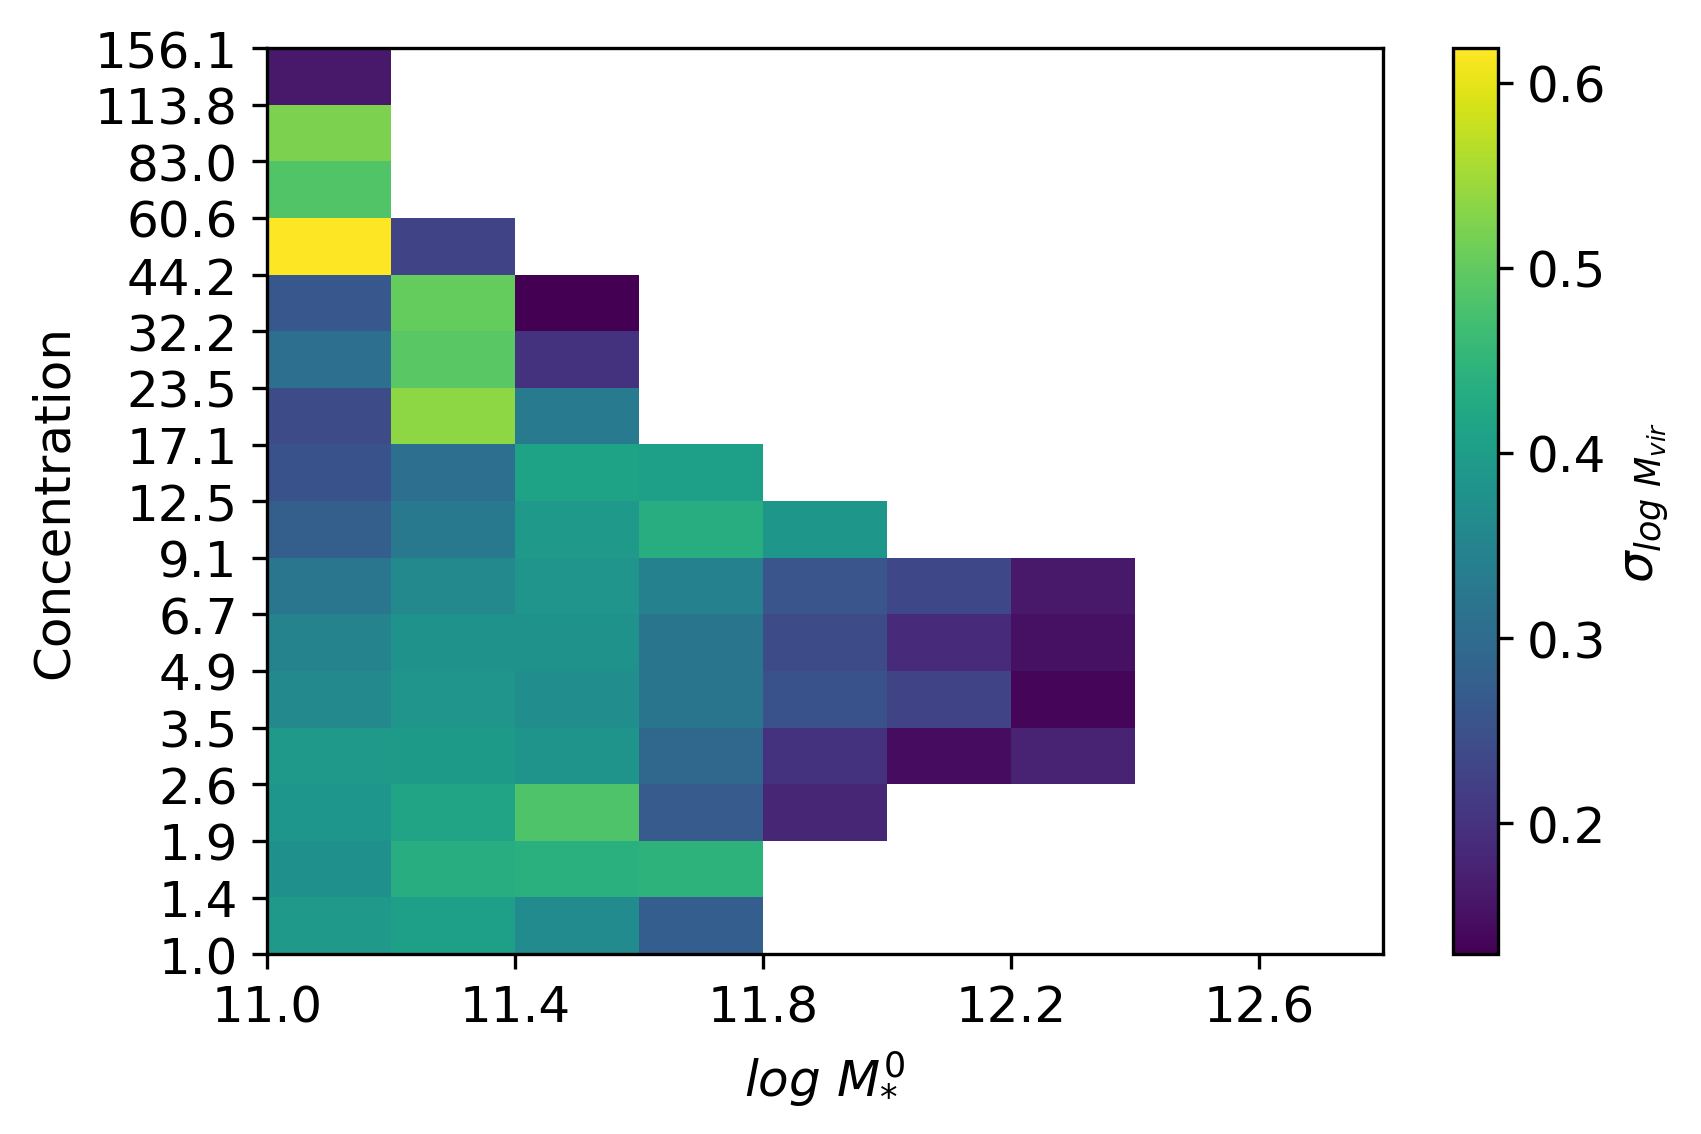

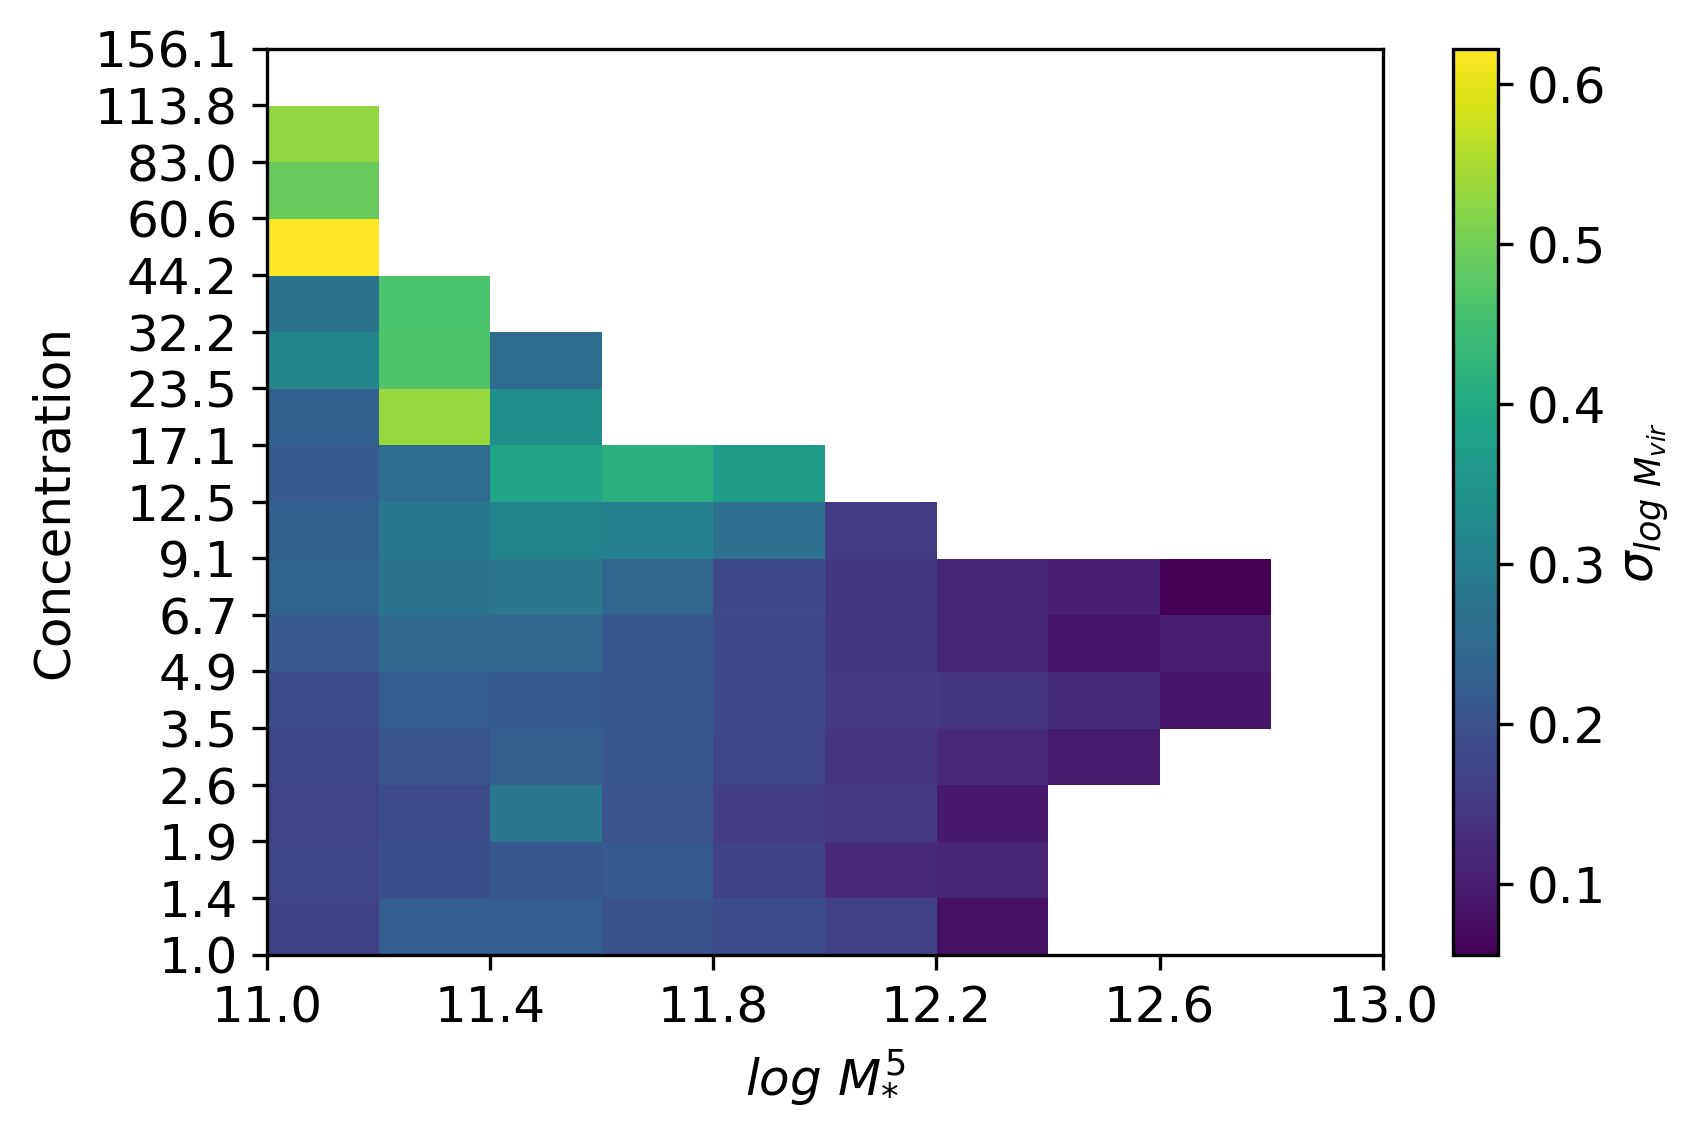

In [103]:
heatmaps.concentration_and_sm_vs_hm_scatter(data_stellar_cut[0]["data"], data_stellar_cut[0]["fit"], 0)
heatmaps.concentration_and_sm_vs_hm_scatter(data_stellar_cut[5]["data"], data_stellar_cut[5]["fit"], 5)

### Old

Just centrals
Total SM (including all sats)


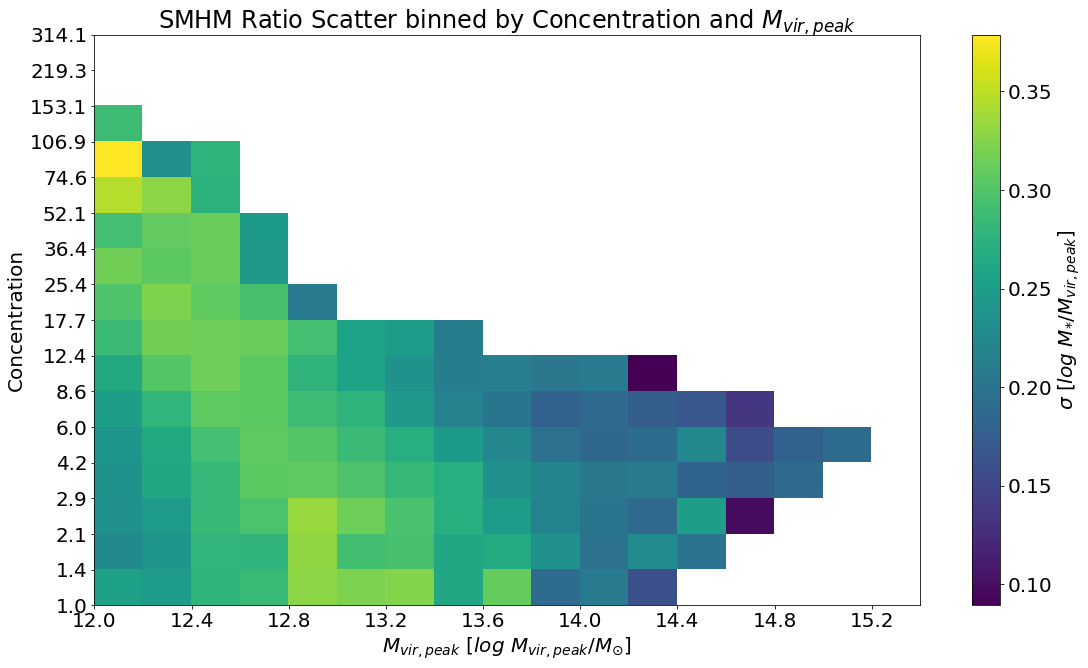

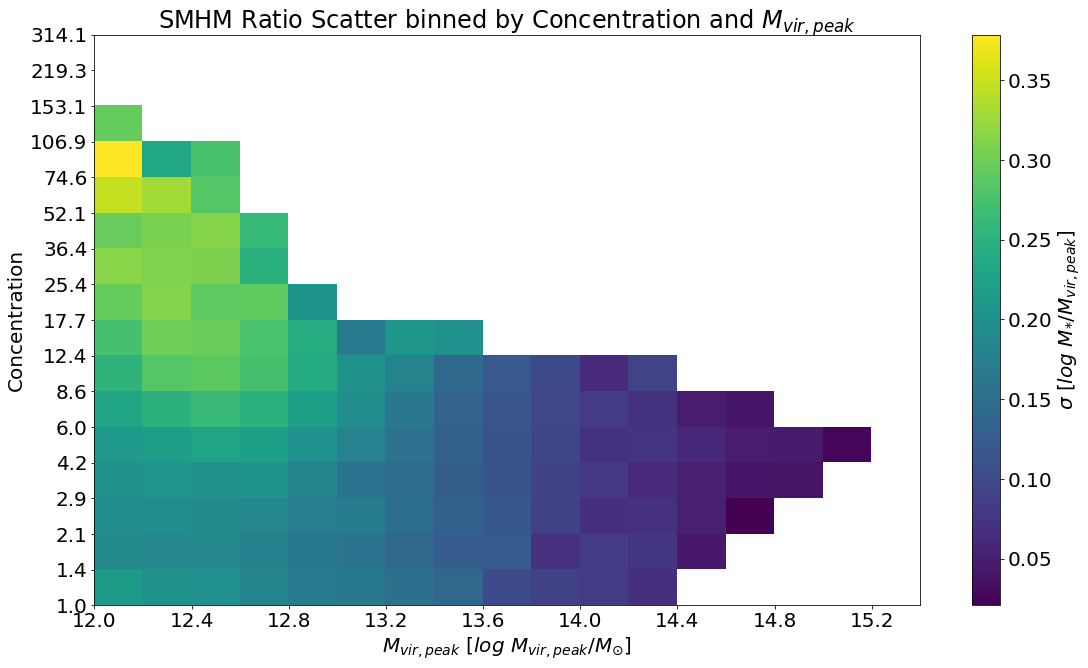

In [283]:
reload(plots)
# should probably have the centrals vs all in the title not just printed...
print("Just centrals")
plots.concentration_vs_scatter(centrals)
print("Total SM (including all sats)")
plots.concentration_vs_scatter(data["all"])

# Age

What about age?

In [548]:
print(data_halo_cut[0].dtype) # no obvious halfmass stellar scale

[('id', '<i8'), ('upid', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('mp', '<f8'), ('sm', '<f8'), ('icl', '<f8'), ('sfr', '<f8'), ('mvir', '<f8'), ('rvir', '<f8'), ('rs', '<f8'), ('Halfmass_Scale', '<f8'), ('scale_of_last_MM', '<f8'), ('M200b', '<f8'), ('M200c', '<f8'), ('Acc_Rate_Inst', '<f8'), ('Acc_Rate_100Myr', '<f8'), ('Acc_Rate_1*Tdyn', '<f8'), ('Acc_Rate_2*Tdyn', '<f8'), ('Acc_Rate_Mpeak', '<f8'), ('Vmax@Mpeak', '<f8')]


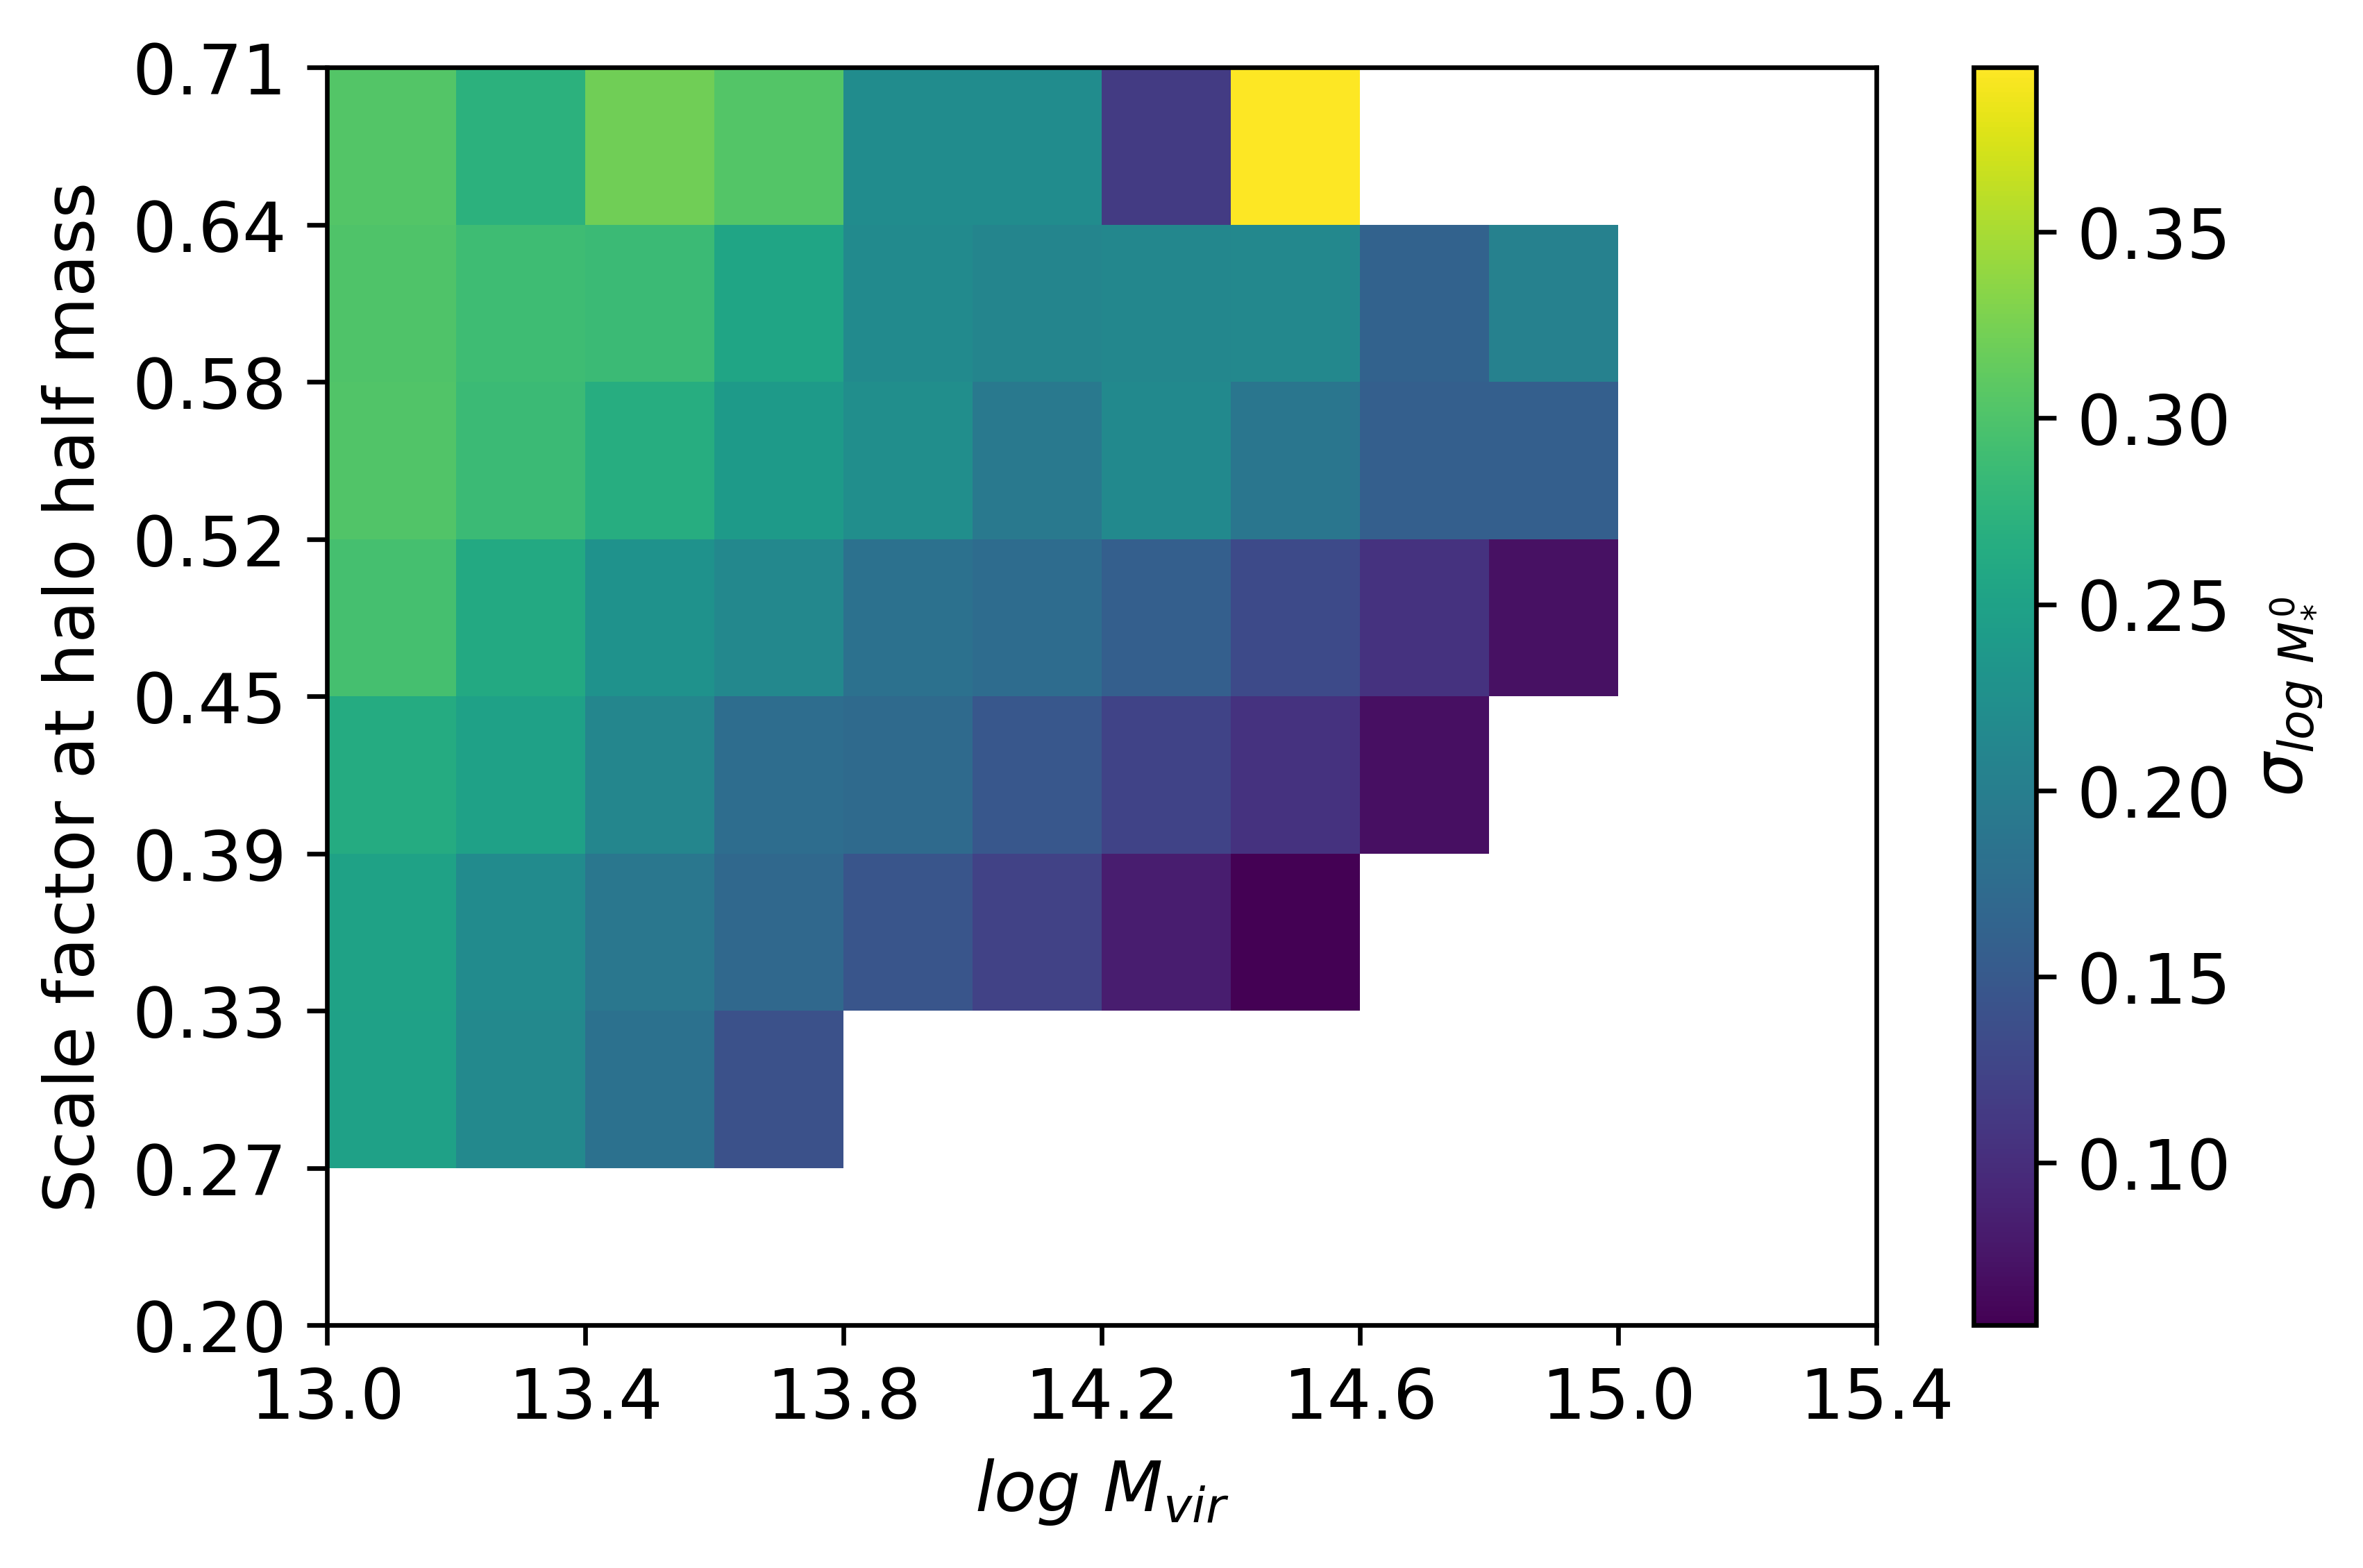

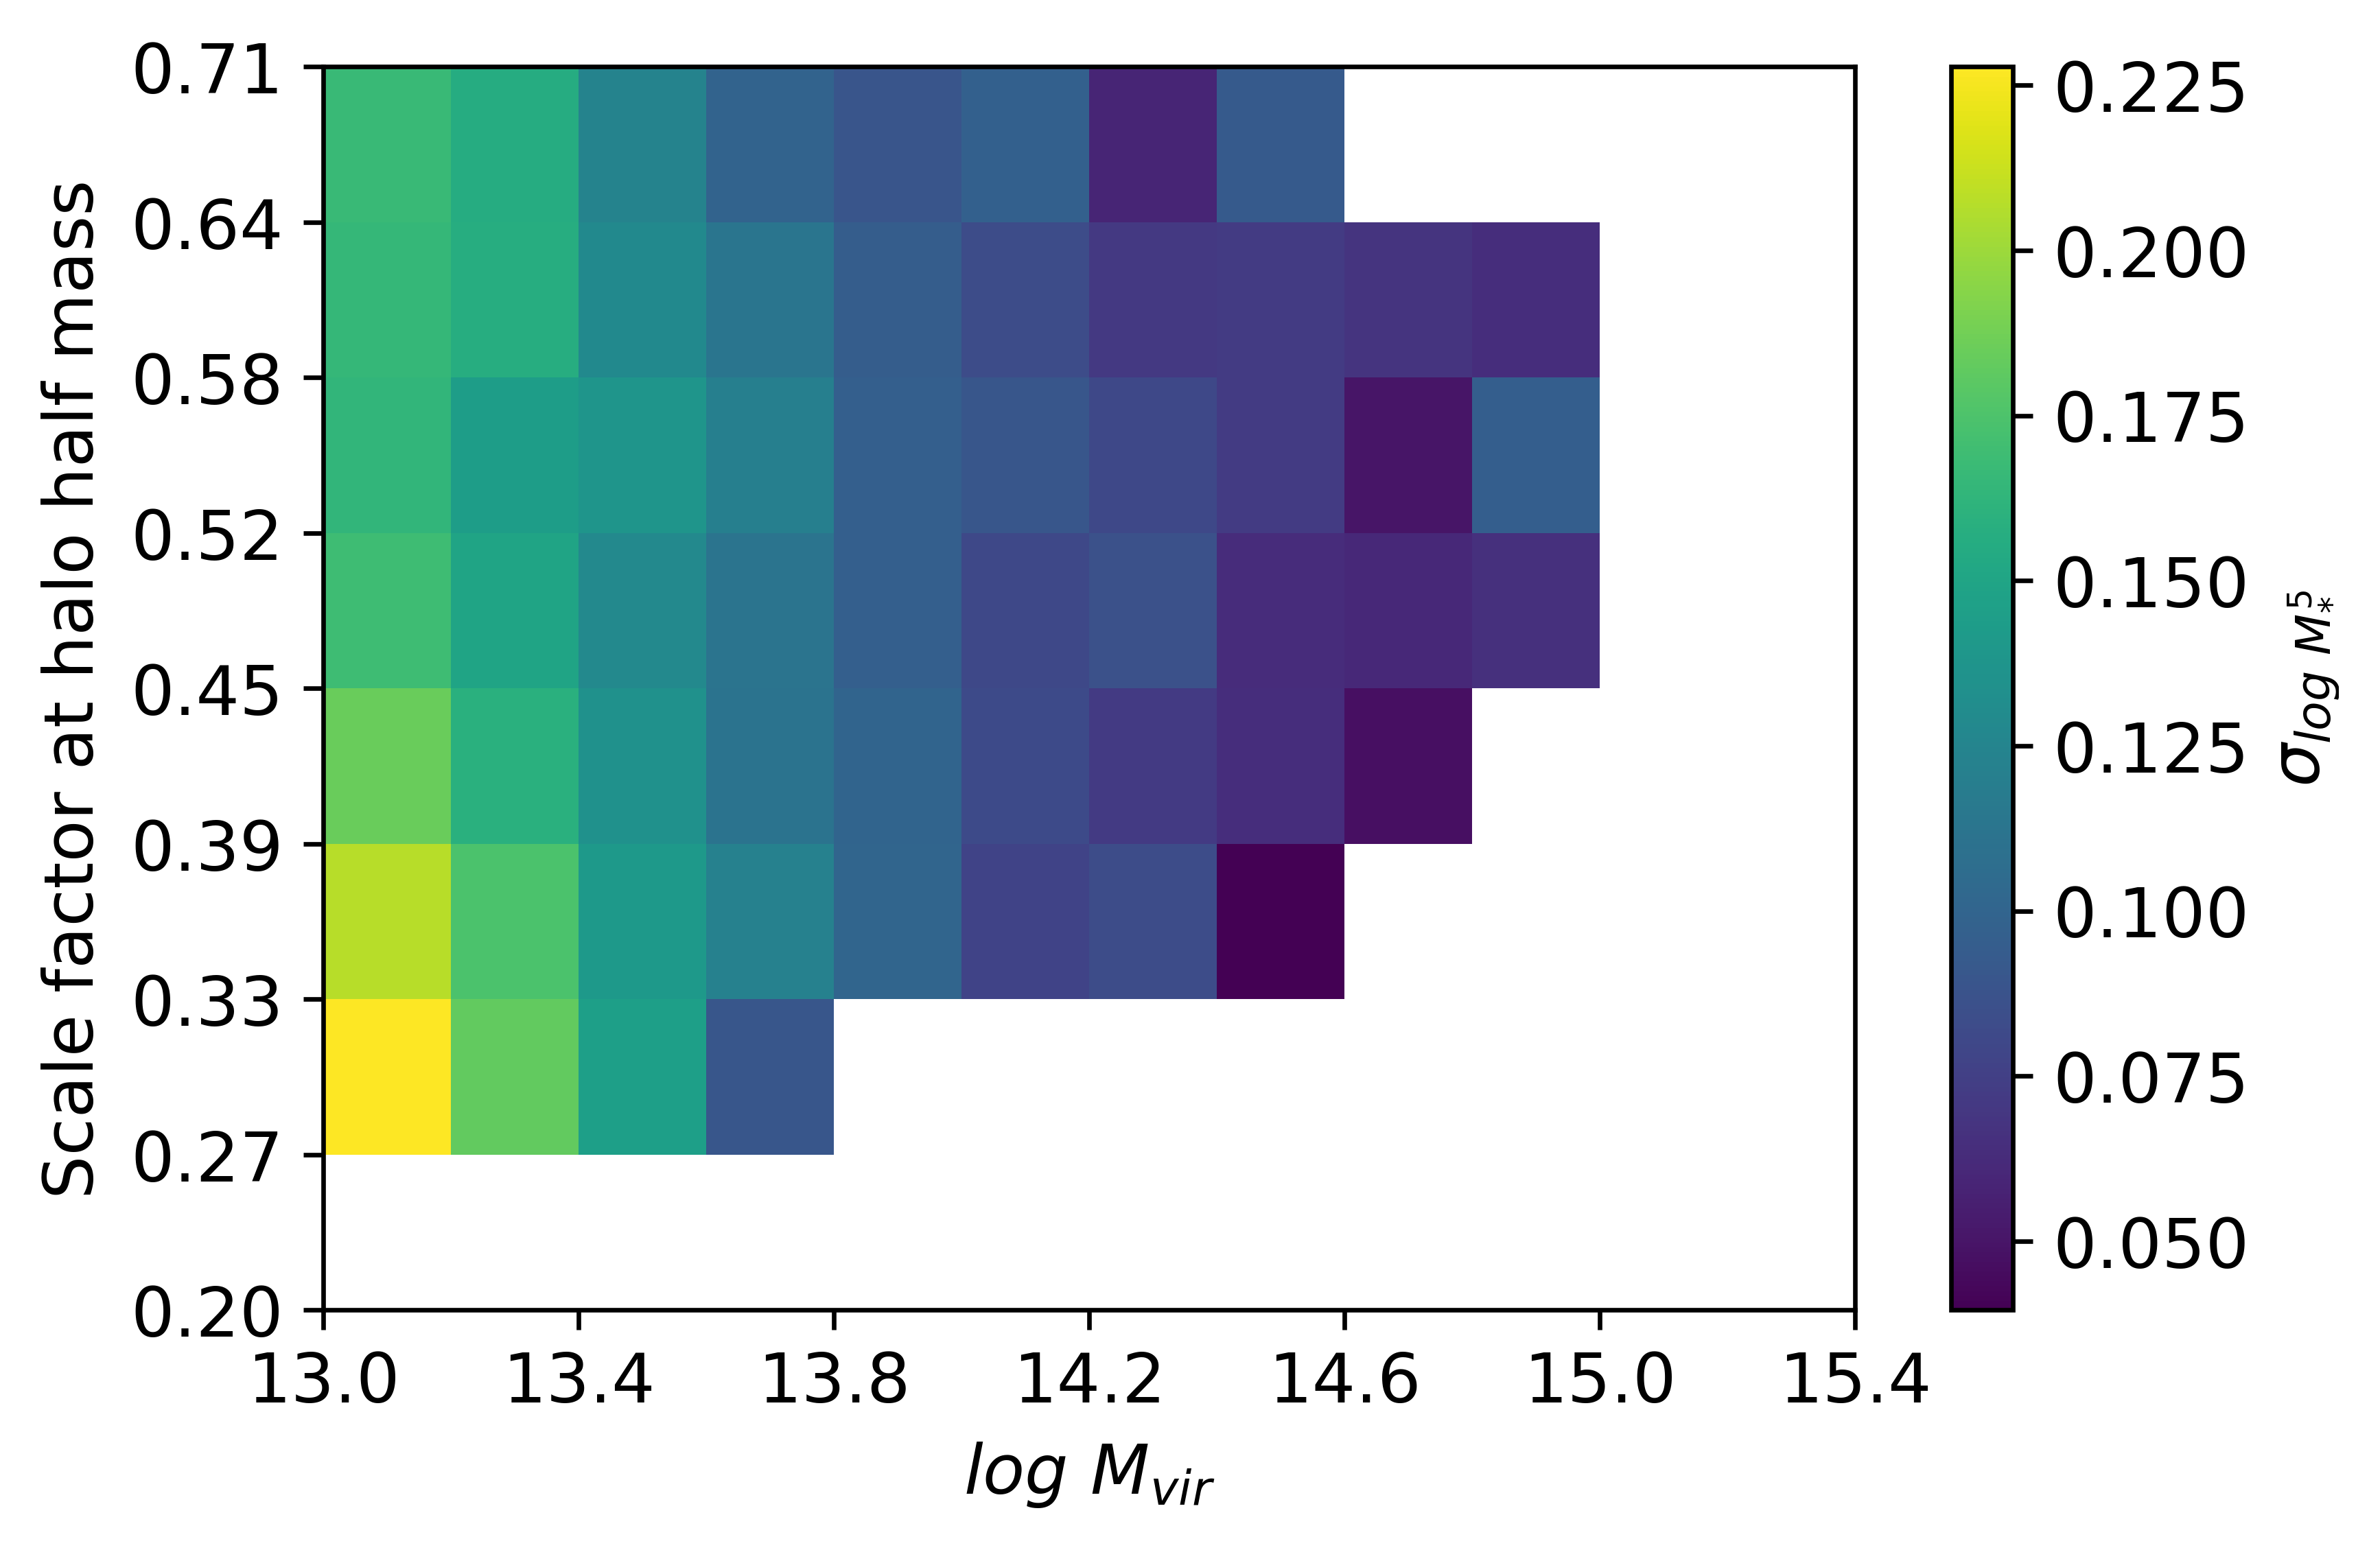

In [111]:
heatmaps.age_and_hm_vs_sm_scatter(data_halo_cut[0]["data"], data_halo_cut[0]["fit"], 0)
heatmaps.age_and_hm_vs_sm_scatter(data_halo_cut[5]["data"], data_halo_cut[5]["fit"], 5)

In [112]:
heatmaps.age_and_sm_vs_hm_scatter(data_stellar_cut[0]["data"], data_stellar_cut[0]["fit"])
heatmaps.age_and_sm_vs_hm_scatter(data_stellar_cut[5]["data"], data_stellar_cut[5]["fit"])

TypeError: age_and_sm_vs_hm_scatter() missing 1 required positional argument: 'n_sats'

# Major Mergers

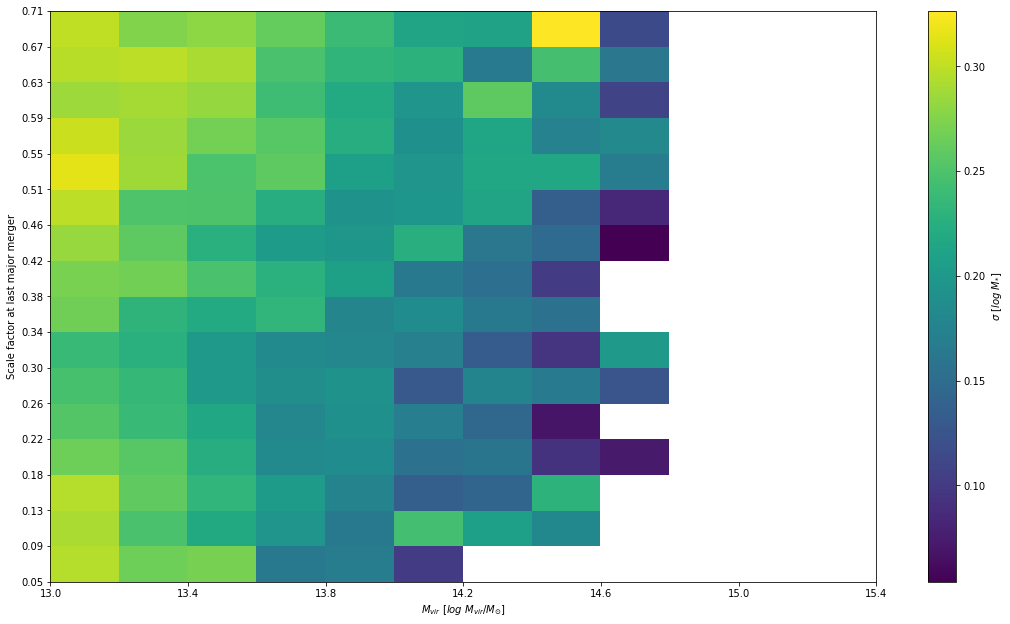

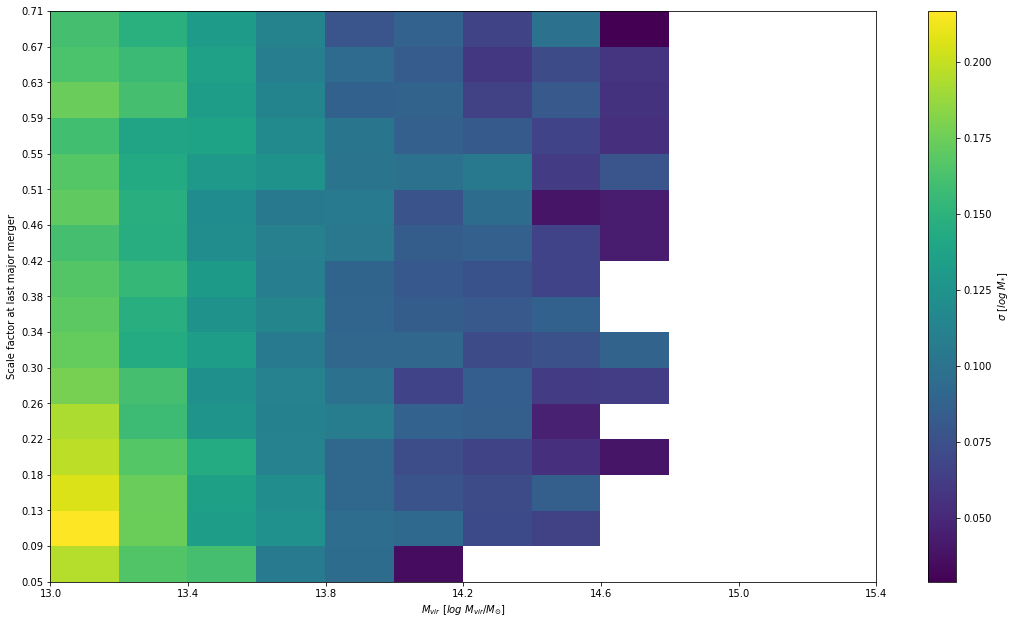

In [184]:
heatmaps.mm_and_hm_vs_sm_scatter(data_halo_cut[0]["data"], data_halo_cut[0]["fit"])
heatmaps.mm_and_hm_vs_sm_scatter(data_halo_cut[5]["data"], data_halo_cut[5]["fit"])

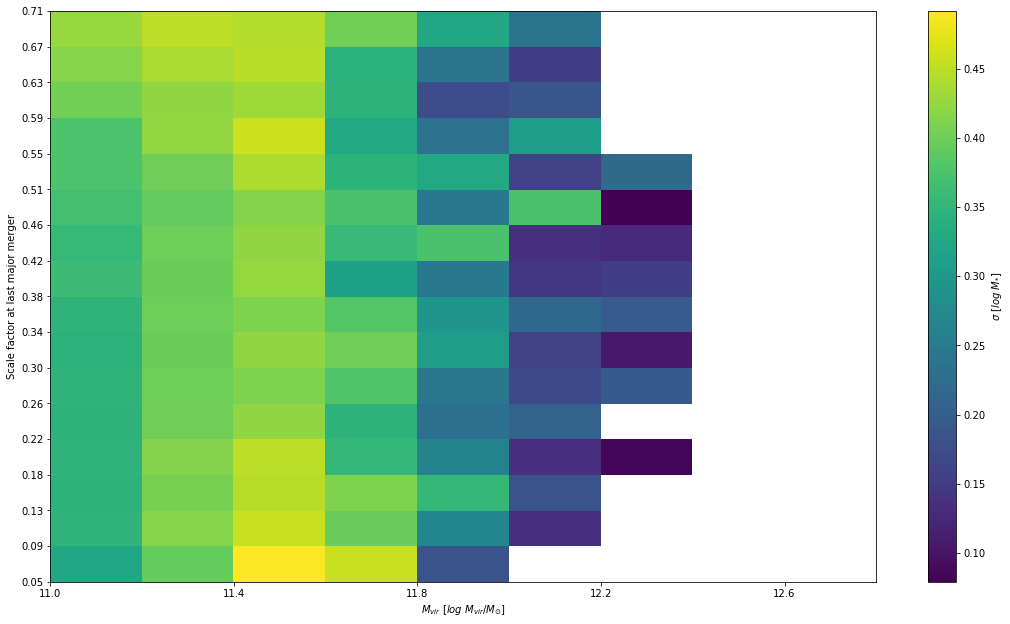

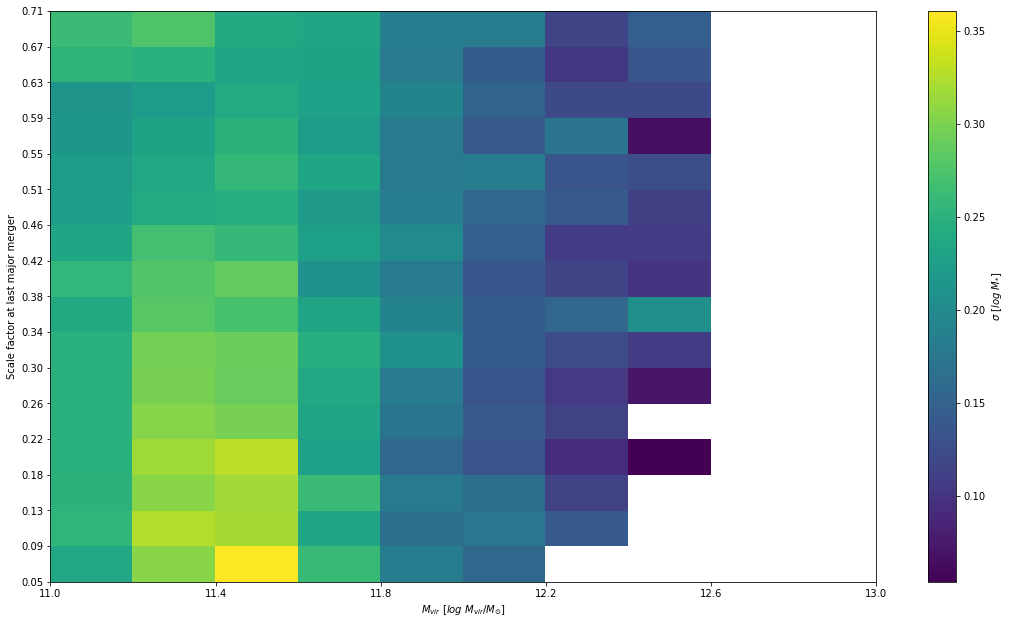

In [183]:
heatmaps.mm_and_sm_vs_hm_scatter(data_stellar_cut[0]["data"], data_stellar_cut[0]["fit"])
heatmaps.mm_and_sm_vs_hm_scatter(data_stellar_cut[5]["data"], data_stellar_cut[5]["fit"])

# Comparison of secondary feature distribution

Let's look at how a selection on stellar mass could bias the secondary features.
1. Select a sample by cutting on some variant of SM
2. Select a sample by matching the halo mass distribution of 1
3. Compare features of 1 and 2

central cuts of (11.8, 12), halo cuts of (12.298320514415717, 12.543750560072244)
872
Bin width is 0.039629056716972144
715
Bin width is 0.020833326443183253
872
Bin width is 0.039629056716972144
715
Bin width is 0.020833326443183253


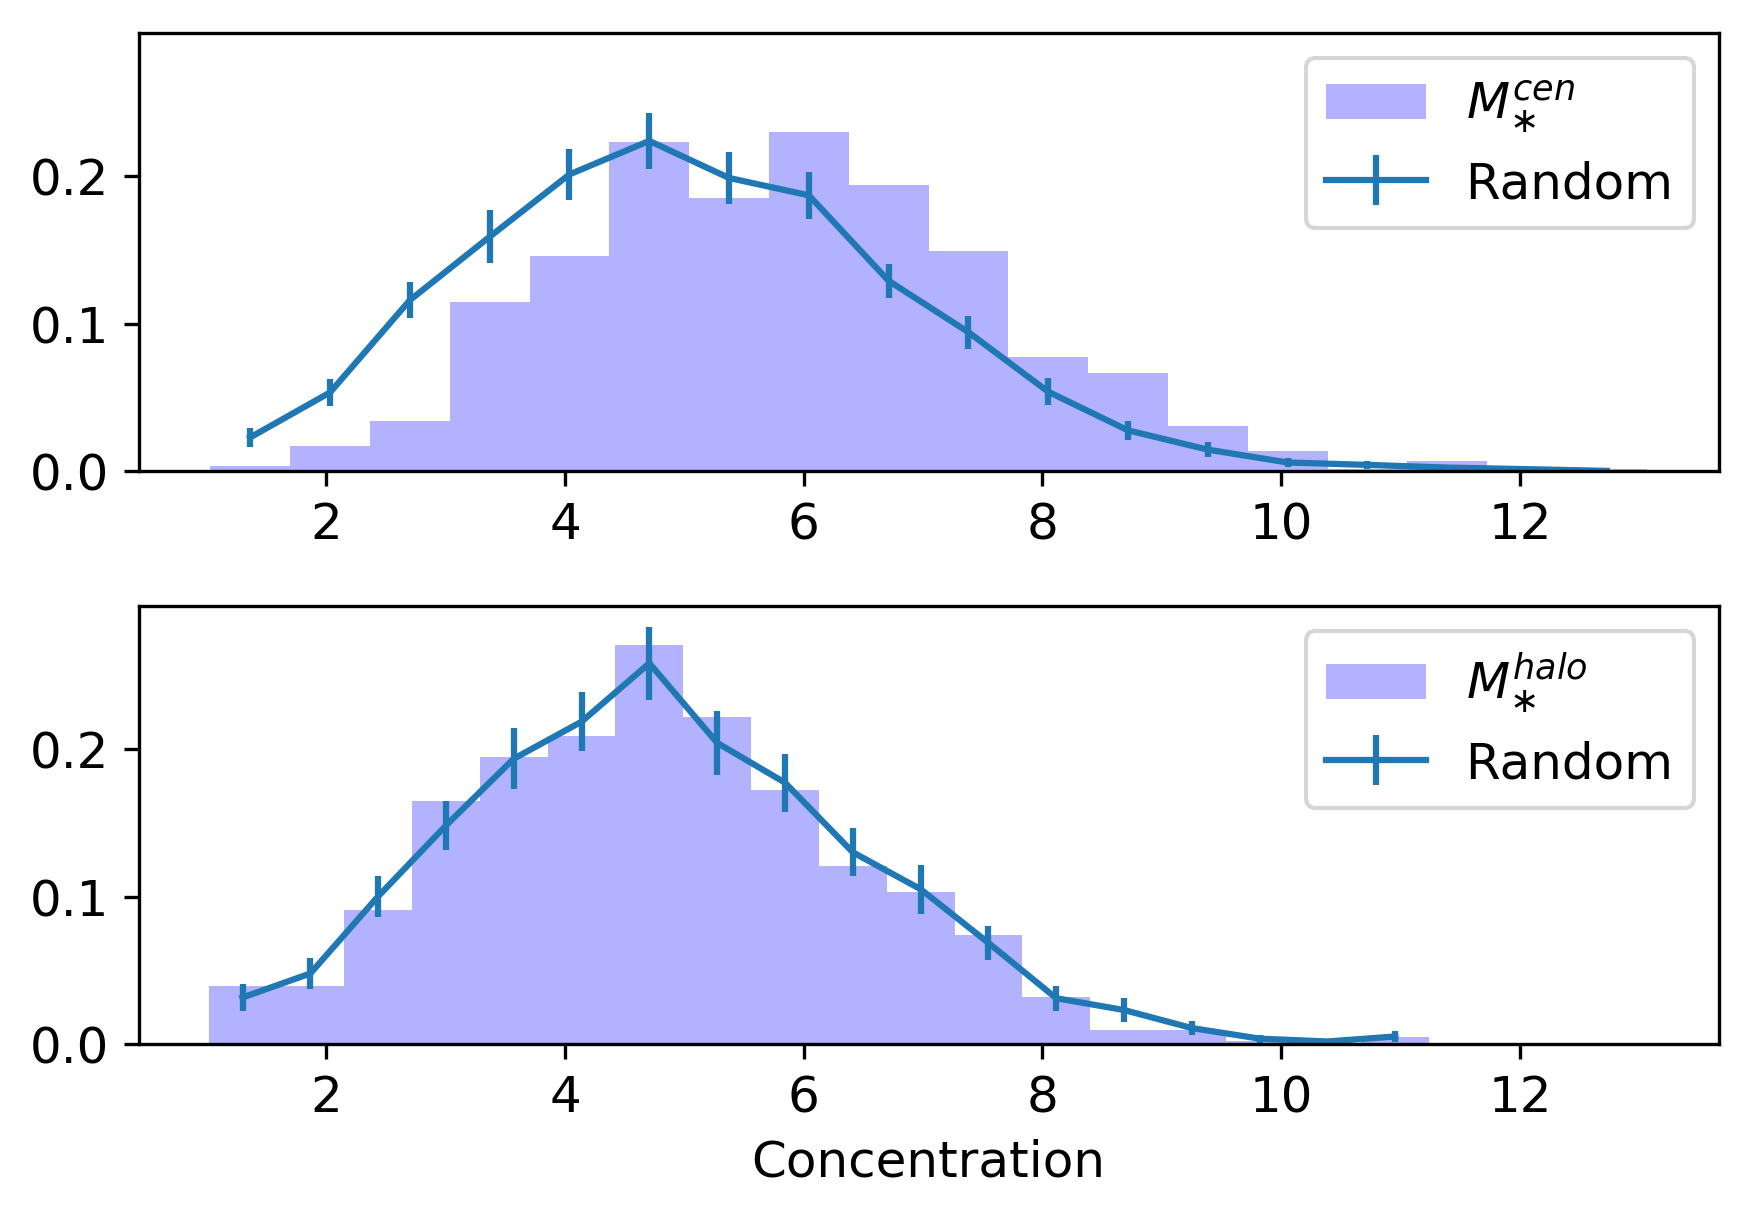

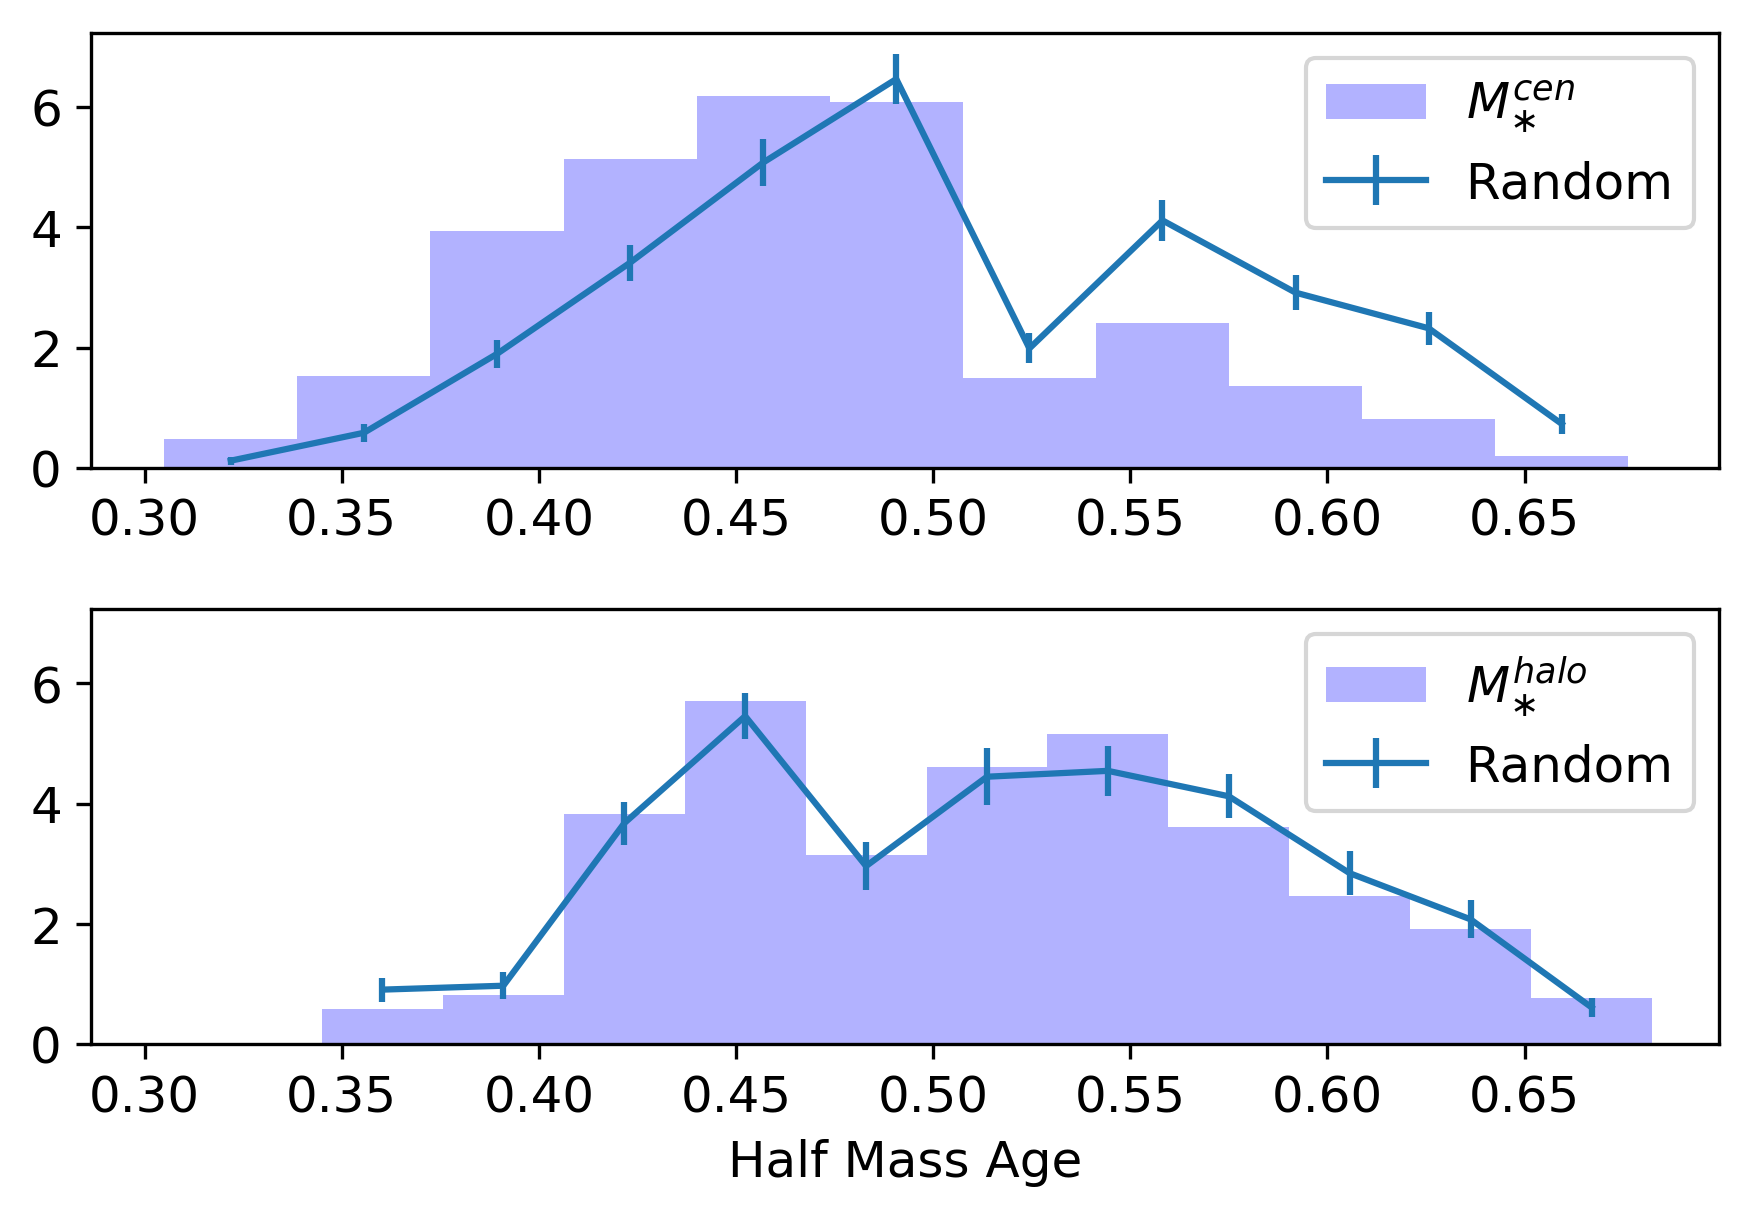

In [175]:
cen_cuts = (11.8, 12)
halo_cuts = tuple(fits.mass_at_density(data_halo_cut, "halo", fits.density_at_mass(
        data_halo_cut, "cen", m)) for m in cen_cuts)
print("central cuts of {}, halo cuts of {}".format(cen_cuts, halo_cuts))

_, axes = plt.subplots(2, 1)
p.same_hm_dist_plots.do_everything(data_halo_cut, "cen", p.same_hm_dist_plots.f_concentration, cuts=cen_cuts, ax=axes[0])
p.same_hm_dist_plots.do_everything(data_halo_cut, "halo", p.same_hm_dist_plots.f_concentration, cuts=halo_cuts, ax=axes[1])
plt.tight_layout()
axes[1].set(**{"xlabel": "Concentration"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})


# You need to think about how you are binning this.
_, axes = plt.subplots(2, 1)
p.same_hm_dist_plots.do_everything(data_halo_cut, "cen", p.same_hm_dist_plots.f_age, cuts=cen_cuts, ax=axes[0], bins=11)
p.same_hm_dist_plots.do_everything(data_halo_cut, "halo", p.same_hm_dist_plots.f_age, cuts=halo_cuts, ax=axes[1], bins=11)
plt.tight_layout()
axes[1].set(**{"xlabel": "Half Mass Age"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})
"""
_, axes = plt.subplots(1, 2)
ax = same_hm_dist_plots.do_everything(data_halo_cut, "cen", same_hm_dist_plots.f_mm, cuts=(11.8, 12), bulk_set={"xlabel": "Scale at last MM"}, ax=axes[0])
ax = same_hm_dist_plots.do_everything(data_halo_cut, "halo", same_hm_dist_plots.f_mm, cuts=(11.8, 12), bulk_set={"xlabel": "Scale at last MM"}, ax=axes[1])
plt.tight_layout()
"""
None